<a href="https://colab.research.google.com/github/YaoYinYing/low-n-protein-engineering/blob/master/Low_N_engineering_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Low-N protein engineering of P450

## Install softwares

In [34]:
#@title Install softwares
import os
import glob
import pathlib
import sys
import time
import traceback
import pickle
import re
from IPython.utils import io
import subprocess
import tqdm.notebook
import urllib3
import gzip
from numba import jit

try:
  from google.colab import files
  IN_COLAB = True
except:
  IN_COLAB = False

TQDM_BAR_FORMAT = '{l_bar}{bar}| {n_fmt}/{total_fmt} [elapsed: {elapsed} remaining: {remaining}]'

JAX_UNIREP_REPO='https://github.com/ElArkk/jax-unirep.git'
DOWNLOAD_PFAM_SCRIPT='https://raw.githubusercontent.com/xqding/PEVAE_Paper/master/pfam_msa/script/download_MSA.py'
ENTREZ_URL='ftp://ftp.ncbi.nlm.nih.gov/entrez/entrezdirect//install-edirect.sh'

ROOT_DIR='.'
TMP_DIR = f"{ROOT_DIR}/tmp"

SCRIPTS_DIR=f'{TMP_DIR}/scripts'
FLAG_DIR=f'{TMP_DIR}/flag'
WEIGHTS_DIR=f'{TMP_DIR}/weights'

JOBS_DIR=f'{ROOT_DIR}/jobs'

RES_DIR=f'{ROOT_DIR}/results'
RES_DIR_MSA=f"{RES_DIR}/MSA"
RES_DIR_BLAST=f"{RES_DIR}/MSA/blast"
RES_DIR_FITNESS=f"{RES_DIR}/fitness"
RES_DIR_SEQ_OUT=f"{RES_DIR}/sequence_out"
RES_DIR_PICKLE=f'{RES_DIR}/pickle'
RES_DIR_REPORT=f'{RES_DIR}/report'
RES_DIR_FEATURE=f'{RES_DIR}/feature'
RES_DIR_FIGURE=f'{RES_DIR}/figure'
pathes=['/usr/local/cuda-11.4/bin']
libpathes=['/usr/local/cuda-11.4/lib64']

CONDA_PATH='/opt/anaconda3'

# if not already installed
total = 3
with tqdm.notebook.tqdm(total=total, bar_format=TQDM_BAR_FORMAT) as pbar:
  for dir in [ROOT_DIR,
              TMP_DIR,FLAG_DIR,WEIGHTS_DIR,SCRIPTS_DIR,
              JOBS_DIR,
              RES_DIR,RES_DIR_MSA,RES_DIR_BLAST,RES_DIR_FITNESS,RES_DIR_SEQ_OUT,RES_DIR_PICKLE,RES_DIR_REPORT,RES_DIR_FEATURE,RES_DIR_FIGURE]:
    os.makedirs(dir, exist_ok=True)
  pbar.update(1)

  for path in pathes:
    if f"{pathlib.Path(path).resolve()}" not in os.environ['PATH']:
      os.environ['PATH'] = f"{pathlib.Path(path).resolve()}:{os.environ['PATH']}"
  '''
  for path in libpathes:
    if f"{pathlib.Path(path).resolve()}" not in os.environ['LD_LIBRARY_PATH']:
      os.environ['LD_LIBRARY_PATH'] = f"{pathlib.Path(path).resolve()}:{os.environ['LD_LIBRARY_PATH'] }"
  '''
  pbar.update(1)


  # weights
  #os.system(f'if [ ! -f {FLAG_DIR}/WEIGHT_READY ]; then cd {WEIGHTS_DIR}; for i in 1900_weights/ 256_weights/ 64_weights/ 1900_weights_random/ 256_weights_random/ 64_weights_random/ evotuned/unirep/ evotuned/random_init/; do echo $i; aws s3 sync --no-sign-request s3://unirep-public/$i $i; done;touch {pathlib.Path(FLAG_DIR).resolve()}/WEIGHT_READY;fi')
  pbar.update(1)
  

  0%|          | 0/3 [elapsed: 00:00 remaining: ?]

##Fetching datat

In [ ]:
#@title Fetching P450 data(210 MB for InterPro ?Did we fetch all the data?)

P450_FASTA_URL="./data/IPR001128.fasta.tar.bz2"
os.system(f'cp {P450_FASTA_URL} {RES_DIR_MSA}')
os.system(f'cd {RES_DIR_MSA}; tar xjvf IPR001128.fasta.tar.bz2; mv IPR001128.fasta.tar.bz2 ..')


P450_TARGET_URL='./data/890.fasta'
os.system(f'cp {P450_TARGET_URL}  {JOBS_DIR}')

P450_BLAST_RES_URL='./data/blast_res_890.fasta.tar.bz2'
os.system(f'cp  {P450_BLAST_RES_URL} {RES_DIR_MSA} && cd {RES_DIR_MSA} &&  tar xvjf blast_res_890.fasta.tar.bz2')


P450_EXPERI_DATA_URL='./data/P450_experi_data_encoded.csv'
os.system(f'cp {P450_EXPERI_DATA_URL}  {RES_DIR_FITNESS}' )


target_fasta = f'{JOBS_DIR}/890.fasta'
target_fasta=pathlib.Path(target_fasta).resolve()
job_name=target_fasta.name

In [36]:
#@title Generate Inputs for Evotuning eUniRep for P450 family
# https://github.com/ivanjayapurna/low-n-protein-engineering/blob/master/pre-evotuning/generate_evotune_inputs_2MS2.ipynb

from Bio import SeqIO
import pandas as pd
import re
from Levenshtein import distance
import numpy as np
import matplotlib.pyplot as plt

## Clean sequence family and do a likelihood profiling

In [37]:
 # Functions:

# read FASTA file:
# input: file name
# output: names and sequences in the file as an array of dim-2 arrays [name, sequence].
def read_fasta(name):
    # Yinying edited here bcs pfam provides stockholm formated file. 
    # PFam use stockholm while InterPro use fasta
    
    fasta_seqs = SeqIO.parse(open( name ), name.suffix.replace(".",''))
    data = []
    for fasta in fasta_seqs:
        data.append([fasta.id, str(fasta.seq).strip()])
    return data


# write FASTA file:
# input: file name; df to write
def write_fasta(name, seqs_df):
    out_file = open(f'{RES_DIR_SEQ_OUT}/{name}_out.fasta', "w")
    for i in range(len(seqs_df)):
        out_file.write('>' + seqs_df.name[i] + '\n')
        out_file.write(seqs_df.sequence[i] + '\n')
    out_file.close()


# input: takes in a sequence
# output: True if a sequence contains only standard amino acids, returns False if contains non-standard ones.
def validate(seq, pattern=re.compile(r'^[FIWLVMYCATHGSQRKNEPD]+$')):
    if (pattern.match(seq)):
        return True
    return False

    
# Remove sequences longer than k residues and with non-standard residues
# inputs: seqs_df = dataframe of name, sequence; k = max lenght of residues to keep
# output: cleaned dataframe
def clean(seqs_df, k):
    # remove sequences with length > 1000 AA's
    rows2drop = []
    for i in range(len(seqs_df)):
        if (len(seqs_df.sequence[i]) > k):
            rows2drop.append(i)

    print('Total number of sequences dropped due to length >', k, ':', len(rows2drop))

    seqs_df = seqs_df.drop(rows2drop).reset_index().drop('index', axis=1)

    print('Total number of sequences remaining:', len(seqs_df))
    
    # remove sequences with invalid AA residues
    # valid_alphabet = ['F','I','W','L','V','M','Y','C','A','T','H','G','S','Q','R','K','N','E','P','D']
    invalid_seqs = []

    for i in range(len(seqs_df)):
        if (not validate(seqs_df.sequence[i])):
            invalid_seqs.append(i)

    print('Total number of invalid sequences dropped:', len(invalid_seqs))

    seqs_df = seqs_df.drop(invalid_seqs).reset_index().drop('index', axis=1)

    print('Total number of valid sequences remaining:', len(seqs_df))
    
    
    seqs_df = seqs_df.drop_duplicates(subset='sequence').reset_index().drop('index', axis=1)

    print('Total sequences remaining after duplicate removal', len(seqs_df))

    
    return seqs_df


# calculate the Levenstein distance of mulitple sequences to a target sequence
# also plots a histogram of distances
# inputs: t_seq = target sequence; seqs_df = dataframe of sequences;
# num_bins = bins for histogram; hist_range = range for histogram
# outputs: numpy array of distances
def lev_dist(t_seq, seqs_df, num_bins=20, hist_range=(0,350)):
    distances = []
    for i in range(len(seqs_df)):
        distances.append(distance(t_seq, seqs_df.sequence[i]))
    distances = np.array(distances)

    mean_dist = np.mean(distances)
    median_dist = np.median(distances)
    min_dist = np.min(distances)
    max_dist = np.max(distances)
    
    print("Mean Levenstein distance:", mean_dist)
    print("Median Levenstein distance:", mean_dist)
    print("Min Levenstein distance:", min_dist)
    print("Max Levenstein distance:", max_dist)

    
    # histogram of Levenstein distances from target sequence
    plt.clf()
    plt.hist(distances, bins=num_bins, range=hist_range)
    plt.show()
    
    return distances



"""
File formatting note.
Data should be preprocessed as a sequence of comma-seperated ints with
sequences  /n seperated
"""

# Lookup tables
aa_to_int = {
    'M':1,
    'R':2,
    'H':3,
    'K':4,
    'D':5,
    'E':6,
    'S':7,
    'T':8,
    'N':9,
    'Q':10,
    'C':11,
    'U':12,
    'G':13,
    'P':14,
    'A':15,
    'V':16,
    'I':17,
    'F':18,
    'Y':19,
    'W':20,
    'L':21,
    'O':22, #Pyrrolysine
    'X':23, # Unknown
    'Z':23, # Glutamic acid or GLutamine
    'B':23, # Asparagine or aspartic acid
    'J':23, # Leucine or isoleucine
    'start':24,
    'stop':25,
}

int_to_aa = {value:key for key, value in aa_to_int.items()}

def get_aa_to_int():
    """
    Get the lookup table (for easy import)
    """
    return aa_to_int

def get_int_to_aa():
    """
    Get the lookup table (for easy import)
    """
    return int_to_aa
    
def aa_seq_to_int(s):
    """
    Return the int sequence as a list for a given string of amino acids
    """
    return [24] + [aa_to_int[a] for a in s] + [25]

def int_seq_to_aa(s):
    """
    Return the int sequence as a list for a given string of amino acids
    """
    return "".join([int_to_aa[i] for i in s])

    
def format_seq(seq,stop=False):
    """
    Takes an amino acid sequence, returns a list of integers in the codex of the babbler.
    Here, the default is to strip the stop symbol (stop=False) which would have 
    otherwise been added to the end of the sequence. If you are trying to generate
    a rep, do not include the stop. It is probably best to ignore the stop if you are
    co-tuning the babbler and a top model as well.
    """
    if stop:
        int_seq = aa_seq_to_int(seq.strip())
    else:
        int_seq = aa_seq_to_int(seq.strip())[:-1]
    return int_seq

def is_valid_seq(seq, max_len=2000):
    """
    True if seq is valid for the babbler, False otherwise.
    """
    l = len(seq)
    valid_aas = "MRHKDESTNQCUGPAVIFYWLO"
    if (l < max_len) and set(seq) <= set(valid_aas):
        return True
    else:
        return False

def fasta_to_input(in_path):
    source = SeqIO.parse(in_path + '.fasta.txt','fasta')
    with open(in_path + "_formatted.fasta.txt", "w") as destination:
        for seq in fasta_seqs:
            seq = seq.strip()
            if is_valid_seq(seq) and len(seq) < 275: 
                formatted = ",".join(map(str,format_seq(seq)))
                destination.write(formatted)
                destination.write('\n')

def seqs_to_input(name, in_seqs, stop=False):
    with open('outputs/' + name + "_formatted.fasta.txt", "w") as destination:
        for seq in in_seqs:
            seq = seq.strip()
            if is_valid_seq(seq): 
                formatted = ",".join(map(str,format_seq(seq, stop=stop)))
                destination.write(formatted)
                destination.write('\n')

In [38]:
!echo $CONDA_PREFIX

/opt/anaconda3


In [ ]:
#@title Read protein family and clean the data for evotuning.
import glob


# input FASTA files:
in_fastas = [pathlib.Path(x).resolve() for x in glob.glob(f"{RES_DIR_MSA}/*") if x.endswith('.fasta')]

# put sequences into a pandas dataframes
sequences_df = pd.concat([pd.DataFrame(read_fasta(in_fastas[i]), columns = ['name', 'sequence']) for i in range(len(in_fastas))], axis=0).reset_index().drop('index', axis=1)

print('Total number of input sequences:', len(sequences_df))

# clean the sequences:
# the number here is the AA length we want - set to 350
clean_seqs_df = clean(sequences_df, 600)

# save clean sequences as a .fasta.txt file
write_fasta('P450_all_sequences_clean', clean_seqs_df)

In [ ]:
#@title Check P450 sequences
sequences_df.head()

In [8]:
#@title load target sequence

targets = read_fasta(target_fasta)
print(targets[0][0])
print(targets[0][1])

NP_001289636.1
MWTILLGLATLAIAYYIHWVNKWKDSKFNGVLPPGTMGLPLIGETIQLSRPSDSLDVHPFIQRKVKRYGPIFKTCLAGRPVVVSTDAEFNHYIMLQEGRAVEMWYLDTLSKFFGLDTEWLKALGLIHKYIRSITLNHFGAESLRERFLPRIEESARETLHYWSTQTSVEVKESAAAMVFRTSIVKMFSEDSSKLLTEGLTKKFTGLLGGFLTLPLNLPGTTYHKCIKDMKQIQKKLKDILEERLAKGVKIDEDFLGQAIKDKESQQFISEEFIIQLLFSISFASFESISTTLTLILNFLADHPDVVKELEAEHEAIRKARADPDGPITWEEYKSMNFTLNVICETLRLGSVTPALLRKTTKEIQIKGYTIPEGWTVMLVTASRHRDPEVYKDPDTFNPWRWKELDSITIQKNFMPFGGGLRHCAGAEYSKVYLCTFLHILFTKYRWRKLKGGKIARAHILRFEDGLYVNFTPKE


In [ ]:
#@title calculate levenstein distance from chosen target sequence
distances = lev_dist(targets[0][1], clean_seqs_df, 30, (0,300))

In [ ]:
#@title partition into the training and 2 validation sets:

clean_seqs_df_copy = clean_seqs_df.copy()
out_domain_val_set = clean_seqs_df_copy.sample(frac=0.1, weights=distances**4, random_state=17)
remainder_df = clean_seqs_df_copy.drop(out_domain_val_set.index)
#train_set = remainder_df.sample(frac=0.889, random_state=17)
#in_domain_val_set = remainder_df.drop(train_set.index)

# set check sizes and levenstein distances
print('Out of domain validation set size:', len(out_domain_val_set))
out_dom_distances = lev_dist(targets[0][1], out_domain_val_set.reset_index().drop('index', axis=1), 30, (0,300))

#print('In domain validation set size:', len(in_domain_val_set))

print('Training set size:', len(remainder_df))
training_distances = lev_dist(targets[0][1], remainder_df.reset_index().drop('index', axis=1), 30, (0,300))

In [ ]:
#@title save to fasta file formats:

write_fasta(f'{job_name}_train_set', remainder_df.reset_index().drop('index', axis=1))
write_fasta(f'{job_name}_out_domain_val_set', out_domain_val_set.reset_index().drop('index', axis=1))
#write_fasta('in_domain_val_set', in_domain_val_set.reset_index().drop('index', axis=1))

## Evotuning (Timekiller! Do it w/ our own GPU server!)

In [6]:
#@title Evotuning
# https://github.com/ElArkk/jax-unirep/blob/master/examples/evotuning.py
"""Evotuning two ways!"""

from pathlib import Path

from jax.random import PRNGKey

from jax_unirep import evotune
from jax_unirep.evotuning_models import mlstm1900
from jax_unirep.utils import dump_params
from jax_unirep.utils import load_params
from functools import partial

# Test sequences:
sequences = [x[1] for x in read_fasta(Path(f'{RES_DIR_SEQ_OUT}/{job_name}_train_set_out.fasta'))]
holdout_sequences = [x[1] for x in read_fasta(Path(f'{RES_DIR_SEQ_OUT}/{job_name}_out_domain_val_set_out.fasta'))]


# The input_shape is always going to be (-1, 26),
# because that is the number of unique AA, one-hot encoded.


n_epochs_config = {"low": 1, "high": 1}
lr_config = {"low": 1e-5, "high": 1e-3}

EVOTUNING_PROJECT=[
    "evotuning_P450_from_global",
    "evotuning_P450_from_randinit",
]


for PROJECT_NAME in EVOTUNING_PROJECT:
    #PROJECT_NAME = "evotuning_P450" #@param {type:"string"}
    init_fun, apply_fun = mlstm1900()
    
    if PROJECT_NAME.endswith("randinit"): 
        _, inital_params = init_fun(PRNGKey(42), input_shape=(-1, 26))
    else:
        inital_params=None
    # 1. Evotuning with Optuna

    study, evotuned_params = evotune(
        sequences=sequences,
        model_func=apply_fun,
        params=inital_params,
        out_dom_seqs=holdout_sequences,
        n_trials=2,
        n_splits=2,
        n_epochs_config=n_epochs_config,
        learning_rate_config=lr_config,
    )
    
    dump_params(evotuned_params, Path(f'{RES_DIR_FEATURE}/{PROJECT_NAME}'))
    print(f"Evotuning done! Find output weights in {RES_DIR_FEATURE}/{PROJECT_NAME}")
    print(study.trials_dataframe())

[I 2021-10-23 12:45:14,115] A new study created in memory with name: no-name-730488c6-8f93-4573-83df-df2dda02d431


right-padding sequences:   0%|          | 0/171927 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

INFO:evotuning:Random batching done: All sequences padded to max sequence length of 600


Iteration:   0%|          | 0/6877 [00:00<?, ?it/s]

INFO:evotuning:Calculations for training set:
INFO:evotuning:Epoch 0: Estimated average loss: 0.2104906141757965. 


created directory at temp


  0%|          | 0/573 [00:00<?, ?it/s]

INFO:evotuning:Split #1


right-padding sequences:   0%|          | 0/171927 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

INFO:evotuning:Random batching done: All sequences padded to max sequence length of 600


Iteration:   0%|          | 0/6877 [00:00<?, ?it/s]

INFO:evotuning:Calculations for training set:
INFO:evotuning:Epoch 0: Estimated average loss: 0.20952515304088593. 


  0%|          | 0/575 [00:00<?, ?it/s]

[I 2021-10-24 08:53:10,047] Trial 0 finished with value: 0.1068151444196701 and parameters: {'n_epochs': 1.0, 'learning_rate': 9.587014351589458e-05}. Best is trial 0 with value: 0.1068151444196701.
INFO:evotuning:Trying out 1.0 epochs with learning rate 0.00018043584194569903.
INFO:evotuning:Split #0


right-padding sequences:   0%|          | 0/171927 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

INFO:evotuning:Random batching done: All sequences padded to max sequence length of 600


Iteration:   0%|          | 0/6877 [00:00<?, ?it/s]

INFO:evotuning:Calculations for training set:
INFO:evotuning:Epoch 0: Estimated average loss: 0.21503762900829315. 


  0%|          | 0/574 [00:00<?, ?it/s]

INFO:evotuning:Split #1


right-padding sequences:   0%|          | 0/171927 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

INFO:evotuning:Random batching done: All sequences padded to max sequence length of 600


Iteration:   0%|          | 0/6877 [00:00<?, ?it/s]

INFO:evotuning:Calculations for training set:
INFO:evotuning:Epoch 0: Estimated average loss: 0.21832290291786194. 


  0%|          | 0/573 [00:00<?, ?it/s]

[I 2021-10-24 23:31:23,581] Trial 1 finished with value: 0.09768655896186829 and parameters: {'n_epochs': 1.0, 'learning_rate': 0.00018043584194569903}. Best is trial 1 with value: 0.09768655896186829.
INFO:evotuning:Optuna done, starting tuning with learning rate=0.00018043584194569903, 


right-padding sequences:   0%|          | 0/343854 [00:00<?, ?it/s]

right-padding sequences:   0%|          | 0/38206 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

INFO:evotuning:Random batching done: All sequences padded to max sequence length of 600


Iteration:   0%|          | 0/13754 [00:00<?, ?it/s]

INFO:evotuning:Calculations for training set:
INFO:evotuning:Epoch 0: Estimated average loss: 0.21258291602134705. 
INFO:evotuning:Calculations for holdout set:
INFO:evotuning:Epoch 0: Estimated average loss: 0.21838925778865814. 


created directory at results/feature/evotuning_P450_from_global
Evotuning done! Find output weights in ./results/feature/evotuning_P450_from_global
   number     value             datetime_start          datetime_complete  \
0       0  0.106815 2021-10-23 12:45:14.203622 2021-10-24 08:53:10.046549   
1       1  0.097687 2021-10-24 08:53:10.052687 2021-10-24 23:31:23.580790   

                duration  params_learning_rate  params_n_epochs     state  
0 0 days 20:07:55.842927              0.000096              1.0  COMPLETE  
1 0 days 14:38:13.528103              0.000180              1.0  COMPLETE  


[I 2021-10-25 03:13:35,200] A new study created in memory with name: no-name-cd46c256-8f0d-4a4b-8498-54c28bf618dd
INFO:evotuning:Trying out 1.0 epochs with learning rate 0.00022990855334515935.
INFO:evotuning:Split #0


right-padding sequences:   0%|          | 0/171927 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

INFO:evotuning:Random batching done: All sequences padded to max sequence length of 600


Iteration:   0%|          | 0/6877 [00:00<?, ?it/s]

INFO:evotuning:Calculations for training set:
INFO:evotuning:Epoch 0: Estimated average loss: 0.1677255779504776. 


  0%|          | 0/572 [00:00<?, ?it/s]

INFO:evotuning:Split #1


right-padding sequences:   0%|          | 0/171927 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

INFO:evotuning:Random batching done: All sequences padded to max sequence length of 600


Iteration:   0%|          | 0/6877 [00:00<?, ?it/s]

INFO:evotuning:Calculations for training set:
INFO:evotuning:Epoch 0: Estimated average loss: 0.16771169006824493. 


  0%|          | 0/575 [00:00<?, ?it/s]

[I 2021-10-25 16:44:40,403] Trial 0 finished with value: 0.15144959092140198 and parameters: {'n_epochs': 1.0, 'learning_rate': 0.00022990855334515935}. Best is trial 0 with value: 0.15144959092140198.
INFO:evotuning:Trying out 1.0 epochs with learning rate 2.057544821566471e-05.
INFO:evotuning:Split #0


right-padding sequences:   0%|          | 0/171927 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

INFO:evotuning:Random batching done: All sequences padded to max sequence length of 600


Iteration:   0%|          | 0/6877 [00:00<?, ?it/s]

INFO:evotuning:Calculations for training set:
INFO:evotuning:Epoch 0: Estimated average loss: 0.16772596538066864. 


  0%|          | 0/574 [00:00<?, ?it/s]

INFO:evotuning:Split #1


right-padding sequences:   0%|          | 0/171927 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

INFO:evotuning:Random batching done: All sequences padded to max sequence length of 600


Iteration:   0%|          | 0/6877 [00:00<?, ?it/s]

INFO:evotuning:Calculations for training set:
INFO:evotuning:Epoch 0: Estimated average loss: 0.16772451996803284. 


  0%|          | 0/574 [00:00<?, ?it/s]

[I 2021-10-26 06:42:02,863] Trial 1 finished with value: 0.15436682105064392 and parameters: {'n_epochs': 1.0, 'learning_rate': 2.057544821566471e-05}. Best is trial 0 with value: 0.15144959092140198.
INFO:evotuning:Optuna done, starting tuning with learning rate=0.00022990855334515935, 


right-padding sequences:   0%|          | 0/343854 [00:00<?, ?it/s]

right-padding sequences:   0%|          | 0/38206 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

INFO:evotuning:Random batching done: All sequences padded to max sequence length of 600


Iteration:   0%|          | 0/13754 [00:00<?, ?it/s]

INFO:evotuning:Calculations for training set:
INFO:evotuning:Epoch 0: Estimated average loss: 0.16773498058319092. 
INFO:evotuning:Calculations for holdout set:
INFO:evotuning:Epoch 0: Estimated average loss: 0.167735755443573. 


created directory at results/feature/evotuning_P450_from_randinit
Evotuning done! Find output weights in ./results/feature/evotuning_P450_from_randinit
   number     value             datetime_start          datetime_complete  \
0       0  0.151450 2021-10-25 03:13:35.205015 2021-10-25 16:44:40.402746   
1       1  0.154367 2021-10-25 16:44:40.411932 2021-10-26 06:42:02.862593   

                duration  params_learning_rate  params_n_epochs     state  
0 0 days 13:31:05.197731              0.000230              1.0  COMPLETE  
1 0 days 13:57:22.450661              0.000021              1.0  COMPLETE  


## Fetch pretrained models of evoltuning P450

In [ ]:
for model in ['evotuning_P450_from_randinit','evotuning_P450_from_global']:
    EVOLTUNING_MODEL_URL=f'https://raw.githubusercontent.com/YaoYinYing/low-n-protein-engineering/master/data/feature/{model}/iter_0/model_weights.pkl'
    MODEL_DIR=f'{RES_DIR_FEATURE}/{model}/iter_0/'
    os.makedirs(MODEL_DIR, exist_ok=True)
    os.system(f'wget -qnc {EVOLTUNING_MODEL_URL} -P {MODEL_DIR}')

In [39]:
#@title Top Training w/ fitness data

from jax_unirep import get_reps, fit
from jax_unirep.utils import load_params
from Bio import SeqIO
import pandas as pd
import glob
import os
import numpy as np

from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import RidgeCV, LinearRegression, HuberRegressor
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsRegressor

import warnings
warnings.filterwarnings('ignore') 

from sklearn.preprocessing import normalize, StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import feather


def read_labeled_data(fitness_csv,seq_col,fit_col): 
  df=pd.read_csv(pathlib.Path(fitness_csv),usecols=[seq_col,fit_col])
  data = []
  for seq, fitness in zip(df.loc[:, seq_col], df.loc[:, fit_col]):
        data.append([str(seq).strip(), fitness])
  return data
# data=read_labeled_data("./P450_experi_data_encoded.csv",'Seq','11H-Cuol')


# save represented dataframe of features as feather
def save_reps(df, path):
  feather.write_dataframe(df, path + '.feather')
  print(path + '.feather', 'saved!')


# read represented dataframe of features as feather
def read_reps(path):
  return feather.read_dataframe(path + '.feather')


def _one_hot(x, k, dtype=np.float32):
  # return np.array(x[:, None] == np.arange(k), dtype)
  return np.array(x[:, None] == np.arange(k))


def aa_seq_to_int(s):
  """Return the int sequence as a list for a given string of amino acids."""
  # Make sure only valid aa's are passed
  if not set(s).issubset(set(aa_to_int.keys())):
    raise ValueError(
      f"Unsupported character(s) in sequence found:"
      f" {set(s).difference(set(aa_to_int.keys()))}"
    )

  return [aa_to_int[a] for a in s]


def aa_seq_to_onehot(seq):
  return 1*np.equal(np.array(aa_seq_to_int(seq))[:,None], np.arange(21)).flatten()
  

def multi_onehot(seqs):
  return np.stack([aa_seq_to_onehot(s) for s in seqs.tolist()])


def distance_matrix(N):
	#A is the one who works with the distance_matrix = np.zeros((N,N))
	for i in range(N):
		for j in range(N):
			# distance_matrix[i,j]=1- ((abs(i-j)/N)**2)
			distance_matrix[i,j]= 1-(abs(i-j)/N)

	return distance_matrix


def confusion_matrix_loss(Y_test,Y_preds_test):

  N = len(Y_test)
  Y_rank_matrix = np.zeros((N,N))
  Y_preds_rank_matrix = np.zeros((N,N))
  for i in range(N):
    for j in range(N):

      if Y_test[i] > Y_test[j]:
        Y_rank_matrix[i,j] = 1
      elif Y_test[i] <= Y_test[j]:
        Y_rank_matrix[i,j] = 0
      if Y_preds_test[i] > Y_preds_test[j]:
        Y_preds_rank_matrix[i,j] = 1
      elif Y_preds_test[i] <= Y_preds_test[j]:
        Y_preds_rank_matrix[i,j] = 0
  confusion_matrix = ~(Y_preds_rank_matrix == Y_rank_matrix)
  # dist_mat = distance_matrix(N)
  # confusion_matrix = confusion_matrix*dist_mat
  loss = np.sum(confusion_matrix)/confusion_matrix.size

  return loss

In [40]:
#@title  load labeled training data
col_seq='Seq' #@param {type:"string"}
col_fitness='11H-Cuol' #@param {type:"string"}
seqs_df = pd.DataFrame(read_labeled_data(f"{RES_DIR_FITNESS}/P450_experi_data_encoded.csv",col_seq,col_fitness), columns = ['sequence', 'fitness'])

In [41]:
# read P450 890 sequence
target_sequence=read_fasta(target_fasta)[0][1]
target_sequence

'MWTILLGLATLAIAYYIHWVNKWKDSKFNGVLPPGTMGLPLIGETIQLSRPSDSLDVHPFIQRKVKRYGPIFKTCLAGRPVVVSTDAEFNHYIMLQEGRAVEMWYLDTLSKFFGLDTEWLKALGLIHKYIRSITLNHFGAESLRERFLPRIEESARETLHYWSTQTSVEVKESAAAMVFRTSIVKMFSEDSSKLLTEGLTKKFTGLLGGFLTLPLNLPGTTYHKCIKDMKQIQKKLKDILEERLAKGVKIDEDFLGQAIKDKESQQFISEEFIIQLLFSISFASFESISTTLTLILNFLADHPDVVKELEAEHEAIRKARADPDGPITWEEYKSMNFTLNVICETLRLGSVTPALLRKTTKEIQIKGYTIPEGWTVMLVTASRHRDPEVYKDPDTFNPWRWKELDSITIQKNFMPFGGGLRHCAGAEYSKVYLCTFLHILFTKYRWRKLKGGKIARAHILRFEDGLYVNFTPKE'

In [42]:
#@title  define hyper params 
PROJECT_NAME='evotuning_P450_from'

gdrive_path=f'{RES_DIR_PICKLE}/'
DIR_PATH = f'{RES_DIR_FEATURE}/{PROJECT_NAME}'
#os.system(f'mkdir -p {pathlib.Path(DIR_PATH).resolve()}')

PARAMS = [ '_global/iter_0','_randinit/iter_0',None, 'one_hot',]

# get representations of data for each params:
N_seqs = len(seqs_df)
print("N_seqs:", N_seqs)

# vary batches based on memory available (i.e. if you have less memory run more batches)
# this google colab can handle around 1000 seqs per batch for sure
N_BATCHES = 6

BATCH_LEN = int(np.ceil(N_seqs/N_BATCHES))

for param in PARAMS:
  # append path to param unless unirep (no param)
  if param == 'one_hot':
    print('getting reps for one hot')
    onehot = multi_onehot(seqs_df.sequence)
    feat_cols = [ 'feat' + str(j) for j in range(1, onehot.shape[1] + 1) ]
    this_df = pd.DataFrame(onehot, columns=feat_cols)
    this_df.insert(0, "sequence", seqs_df.sequence)
    this_df.insert(1, "fitness", seqs_df.fitness)

    save_reps(this_df, gdrive_path + 'one_hot')

    continue

  elif param is None:
    name = 'unirep'

  else:
    name = f'{PROJECT_NAME}-{param}'.replace("/",'_')
    # param is the second element of returned tuple
    # fixed by Yinying
    param = load_params(DIR_PATH + param)[1]

  print('getting reps for', name)
  #print(param)
  # get 1st sequence
  reps, _, _ = get_reps(seqs_df.sequence[0], params=param)
  feat_cols = [ 'feat' + str(j) for j in range(1, reps.shape[1] + 1) ]
  this_df = pd.DataFrame(reps, columns=feat_cols)
  this_df.insert(0, "sequence", seqs_df.sequence[0])
  this_df.insert(1, "fitness", seqs_df.fitness[0])

  # get the rest in batches
  for i in range(N_BATCHES):
    this_unirep, _, _ = get_reps(seqs_df.sequence[ (1 + i*BATCH_LEN) : min( 1 + (i+1)*BATCH_LEN, N_seqs ) ] , params=param)
    this_unirep_df = pd.DataFrame(this_unirep, columns=feat_cols)
    this_unirep_df.insert(0, "sequence", seqs_df.sequence[ (1 + i*BATCH_LEN) : min( 1 + (i+1)*BATCH_LEN, N_seqs ) ].reset_index(drop=True))
    this_unirep_df.insert(1, "fitness", seqs_df.fitness[ (1 + i*BATCH_LEN) : min( 1 + (i+1)*BATCH_LEN, N_seqs ) ].reset_index(drop=True))
    this_df = pd.concat([this_df.reset_index(drop=True), this_unirep_df.reset_index(drop=True)]).reset_index(drop=True)

  save_reps(this_df, gdrive_path + name)

N_seqs: 84
getting reps for evotuning_P450_from-_global_iter_0
./results/pickle/evotuning_P450_from-_global_iter_0.feather saved!
getting reps for evotuning_P450_from-_randinit_iter_0
./results/pickle/evotuning_P450_from-_randinit_iter_0.feather saved!
getting reps for unirep
./results/pickle/unirep.feather saved!
getting reps for one hot
./results/pickle/one_hot.feather saved!


In [43]:
# load the reps you want into dataframes
FEATHER_PATH = gdrive_path 

unirep_df = read_reps(FEATHER_PATH + 'unirep')
eunirep_df = read_reps(FEATHER_PATH + 'evotuning_P450_from-_global_iter_0')
rand_eunirep_df=read_reps(FEATHER_PATH + 'evotuning_P450_from-_randinit_iter_0')
onehot_df = read_reps(FEATHER_PATH + 'one_hot')

dfs = [unirep_df, eunirep_df, onehot_df,rand_eunirep_df]
df_names = ['unirep', 'eunirep', 'one hot','rand_eunirep']

  0%|          | 0/32 [elapsed: 00:00 remaining: ?]

<Figure size 432x288 with 0 Axes>

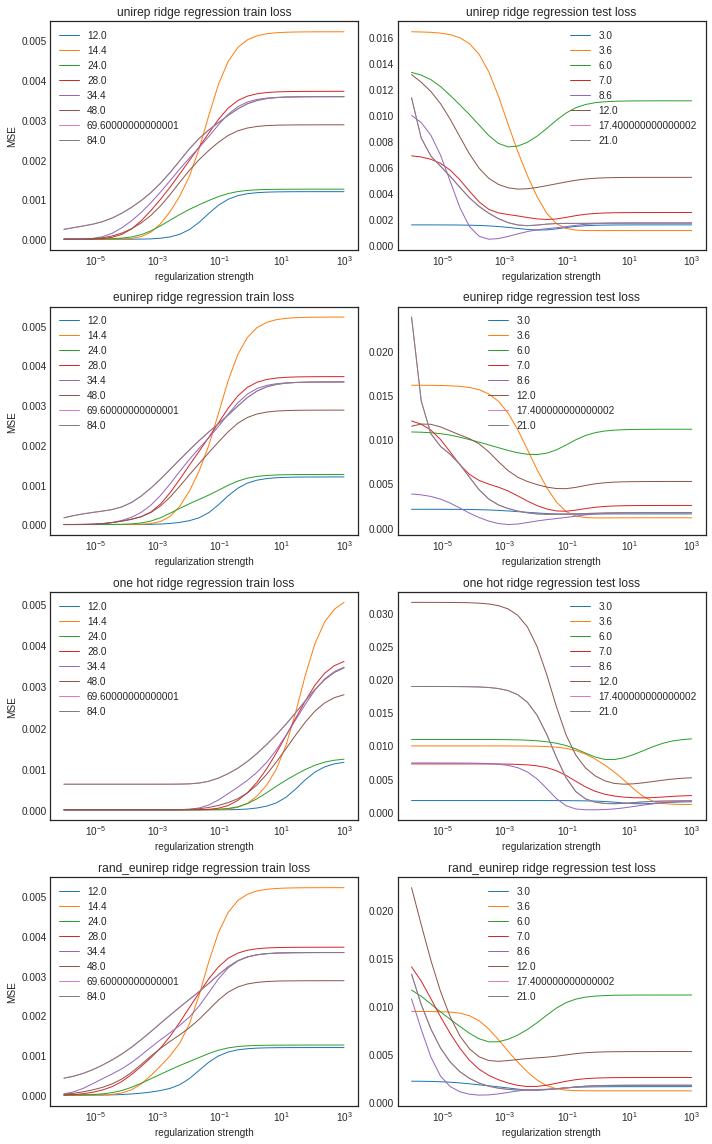

In [44]:
# randomly select subset of sequence as input data
np.random.seed(42)
rndperm = np.random.permutation(dfs[0].shape[0])

BATCH_SIZES = [12,15,24,28,35,48,70,84]
batch_size_list = (np.array(BATCH_SIZES)/0.8).astype("int")

plt.clf()

fig = plt.figure(figsize=(10,4*len(dfs)))
plt.style.use('seaborn-white')
alpha_vals = np.logspace(-6,3,30)

total=len(dfs)*len(batch_size_list)
pbar=tqdm.notebook.tqdm(total=total, bar_format=TQDM_BAR_FORMAT)

for i in range(len(dfs)):
    ax1 = fig.add_subplot(len(dfs),2,(2*i+1), title=df_names[i] + " ridge regression train loss")
    ax2 = fig.add_subplot(len(dfs),2,(2*i+2), title=df_names[i] + " ridge regression test loss")
    
    df = dfs[i]
    for batch_size in batch_size_list:
        pbar.update(1)
        X = df.loc[rndperm[:batch_size], df.columns[2:]]
        Y = df.loc[rndperm[:batch_size], "fitness"]

        
        alpha_list = []
        train_loss_list = []
        test_loss_list = []
        
        for alpha_i in alpha_vals:
            #print(f'df\t{i}: \tbatch_size\t{batch_size}\talpha_i\t{alpha_i}')
            
            # train-test split for both 
            X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

            # ridge regression model setup
            kfold = KFold(n_splits=10, random_state=42, shuffle=True)

            model = RidgeCV(alphas=[alpha_i], cv=kfold)

            # fit the model
            model.fit(X_train, Y_train)

            # predict fitness to get train and test losses
            Y_train_preds = model.predict(X_train)
            Y_test_preds = model.predict(X_test)

            # train_loss = np.linalg.norm(Y_train_preds - Y_train)
            # test_loss = np.linalg.norm(Y_test_preds - Y_test)
            train_loss = np.mean((Y_train_preds - Y_train)**2)
            test_loss = np.mean((Y_test_preds - Y_test)**2)

            alpha_list.append(model.alpha_)
            train_loss_list.append(train_loss)
            test_loss_list.append(test_loss)
        '''
        print(f'')
        print(f'alpha_list={alpha_list}')
        print(f'train_loss_list={train_loss_list}')
        print(f'test_loss_list={test_loss_list}')
        '''
        # plot train and test losses
        ax1.plot(alpha_list, train_loss_list,linewidth=1)
        ax2.plot(alpha_list, test_loss_list,linewidth=1)

    ax1.legend(batch_size_list*0.8)
    ax1.set_xscale("log")
    ax1.set_xlabel("regularization strength")
    ax1.set_ylabel("MSE")
    ax2.legend(batch_size_list*0.2)
    ax2.set_xscale("log")
    ax2.set_xlabel("regularization strength")
    ax1.set_ylabel("MSE")

plt.tight_layout()
plt.show()

  0%|          | 0/8 [elapsed: 00:00 remaining: ?]

<Figure size 432x288 with 0 Axes>

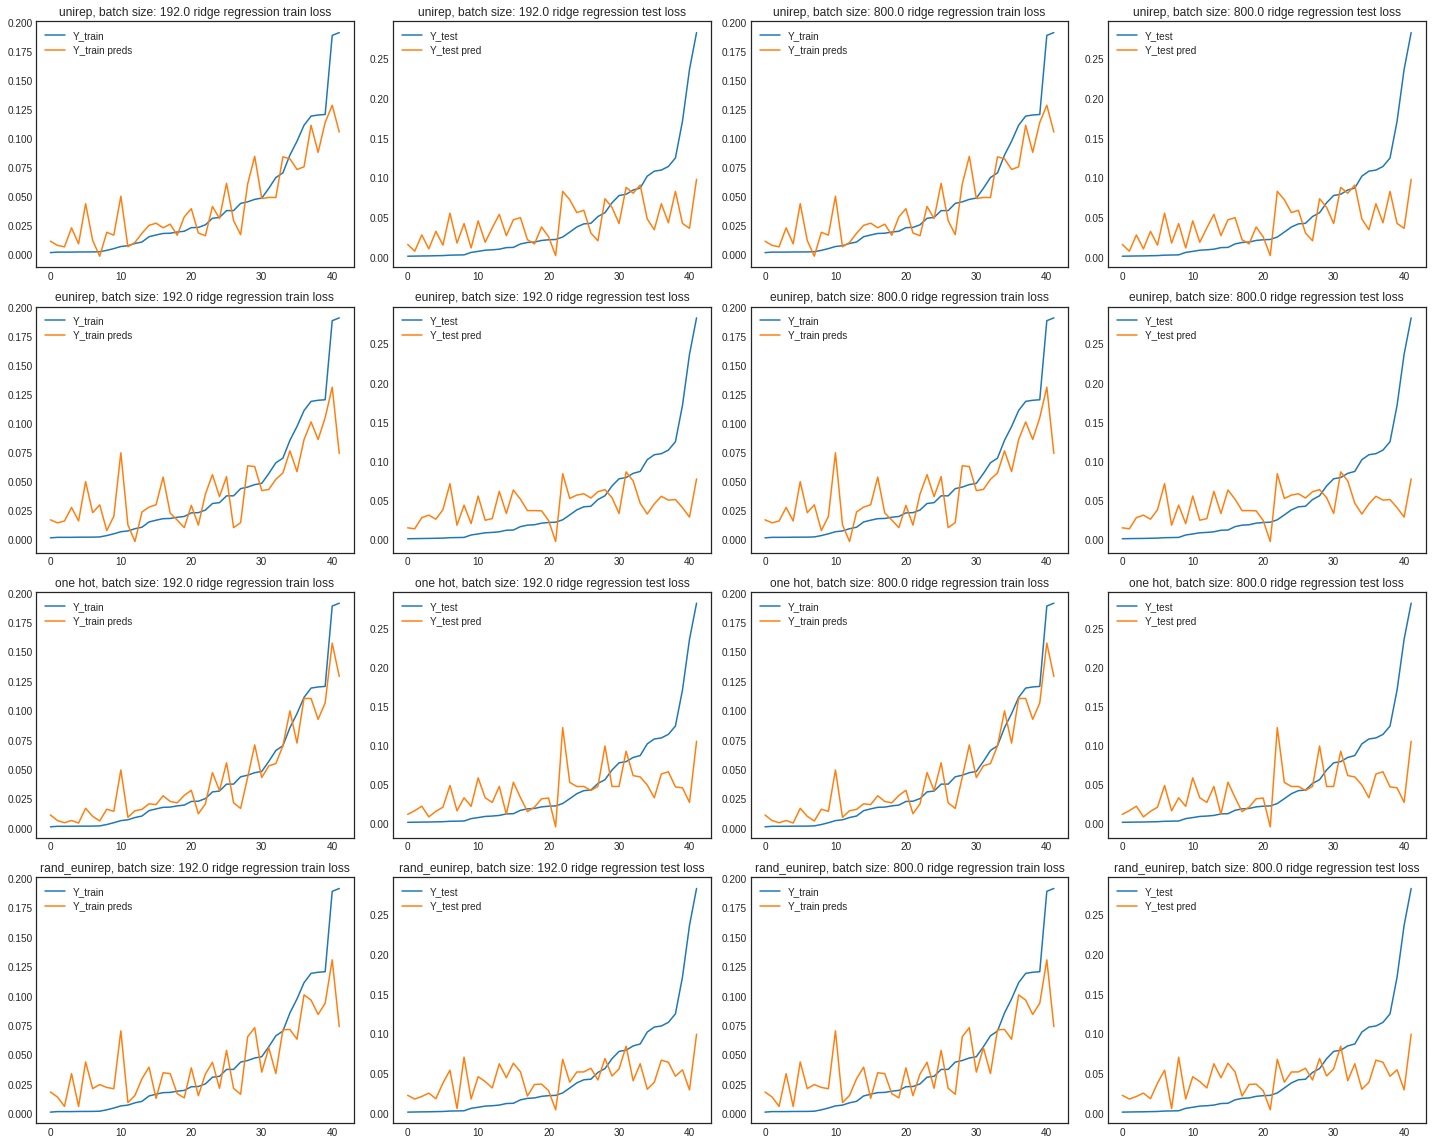

In [64]:
# Train for Hyper parameters
# HYPER_PARAM
ALPHAS = [ 0.001, 0.015,1,0.001]
# ALPHAS = [ 0.0001, 0.00015,1,0.0001]

BATCH_SIZES = [96*2,800]
SPLIT = 0.5

batch_size_list = (np.array(BATCH_SIZES)/SPLIT).astype("int")

# randomly select subset of sequence as input data
np.random.seed()
rndperm = np.random.permutation(dfs[0].shape[0])

plt.clf()

fig = plt.figure(figsize=(10*len(BATCH_SIZES) ,4*len(dfs)))
plt.style.use('seaborn-white')

total=len(dfs)*len(batch_size_list)
pbar=tqdm.notebook.tqdm(total=total, bar_format=TQDM_BAR_FORMAT)
for i in range(len(dfs)):

  df = dfs[i]
  for j in range(len(batch_size_list)):
    pbar.update(1)
    X = df.loc[rndperm[:batch_size_list[j]], df.columns[2:]]
    Y = df.loc[rndperm[:batch_size_list[j]], "fitness"]

    # train-test split for both 
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=SPLIT, random_state=1717)

    # ridge regression model setup
    kfold = KFold(n_splits=10, random_state=1717, shuffle=True)

    model = RidgeCV(alphas=[ALPHAS[i]], cv=kfold)

    # fit the model
    model.fit(X_train, Y_train)

    # predict fitness to get train and test losses
    Y_train_preds = model.predict(X_train)
    Y_test_preds = model.predict(X_test)

    # train_loss = np.linalg.norm(Y_train_preds - Y_train)
    # test_loss = np.linalg.norm(Y_test_preds - Y_test)
    train_loss = np.mean((Y_train_preds - Y_train)**2)
    test_loss = np.mean((Y_test_preds - Y_test)**2)

    ax1 = fig.add_subplot(len(dfs),len(BATCH_SIZES)*2,(4*i+2*j+1), title=df_names[i] + ", batch size: " + str(batch_size_list[j]*(1-SPLIT)) + " ridge regression train loss")
    ax1.plot(np.arange(len(Y_train)), np.array(Y_train)[np.argsort(Y_train)])
    ax1.plot(np.arange(len(Y_train)), np.array(Y_train_preds)[np.argsort(Y_train)])
    ax1.legend(['Y_train','Y_train preds'])

    ax2 = fig.add_subplot(len(dfs),len(BATCH_SIZES)*2,(4*i+2*j+2), title=df_names[i] + ", batch size: " + str(batch_size_list[j]*SPLIT) + " ridge regression test loss")
    ax2.plot(np.arange(len(Y_test)), np.array(Y_test)[np.argsort(Y_test)])
    ax2.plot(np.arange(len(Y_test)), np.array(Y_test_preds)[np.argsort(Y_test)])
    ax2.legend(['Y_test','Y_test pred'])

plt.tight_layout()
plt.show()

[10, 15, 20, 25, 30, 35, 40]


  0%|          | 0/28 [elapsed: 00:00 remaining: ?]

  0%|          | 0/560 [elapsed: 00:00 remaining: ?]

  0%|          | 0/56000 [elapsed: 00:00 remaining: ?]

unirep [0.8116883116883117, 1.2066365007541477, 1.2779552715654952, 1.2232415902140672, 1.08359133126935, 1.2232415902140672, 1.355421686746988, 1.228878648233487, 1.36986301369863, 1.1678832116788322, 0.9508716323296356, 1.3493253373313343, 1.5797788309636651, 1.4195583596214512, 1.1730205278592374, 1.225114854517611, 1.0736196319018405, 1.1627906976744187, 1.5600624024960998, 1.2517385257301807] Mean Score: 1.2347140978244426
eunirep [1.2987012987012987, 1.3574660633484164, 1.597444089456869, 1.2232415902140672, 1.238390092879257, 1.3761467889908257, 1.355421686746988, 1.228878648233487, 1.21765601217656, 1.3138686131386863, 1.109350237717908, 1.0494752623688155, 1.4218009478672986, 1.2618296529968454, 1.3196480938416422, 1.225114854517611, 1.2269938650306749, 1.0174418604651163, 1.4040561622464898, 1.2517385257301807] Mean Score: 1.274733217333452
one hot [1.1363636363636362, 1.3574660633484164, 1.4376996805111821, 1.3761467889908257, 1.238390092879257, 1.3761467889908257, 1.3554216

rand_eunirep [1.0638297872340425, 1.2486992715920917, 1.215644820295983, 1.2319228709159078, 1.2295081967213115, 1.1771000535045477, 1.1616161616161615, 1.0703363914373087, 1.2304779933743493, 1.1837364899639733, 0.9952854897852279, 1.2073490813648293, 1.0956175298804782, 1.2725344644750796, 1.0684798445847499, 1.377848436671966, 1.1806981519507187, 1.1352885525070955, 1.1563599798893915, 1.1225444340505146] Mean Score: 1.1712439000907864
unirep [1.0217113665389528, 1.036970243462579, 1.1138014527845037, 1.1791383219954648, 1.1637931034482758, 1.0333489901362143, 1.097972972972973, 1.0657193605683837, 1.234076433121019, 1.2200632625395391, 1.1695906432748537, 1.0960105217010083, 1.0993657505285412, 1.1450381679389312, 1.1106364801366937, 1.1673151750972763, 1.1669658886894074, 1.0420841683366733, 1.0651896037494675, 1.0620915032679739] Mean Score: 1.1145441705144368
eunirep [1.1068539804171988, 1.036970243462579, 1.2106537530266344, 1.1791383219954648, 1.206896551724138, 1.174260216063

<Figure size 432x288 with 0 Axes>

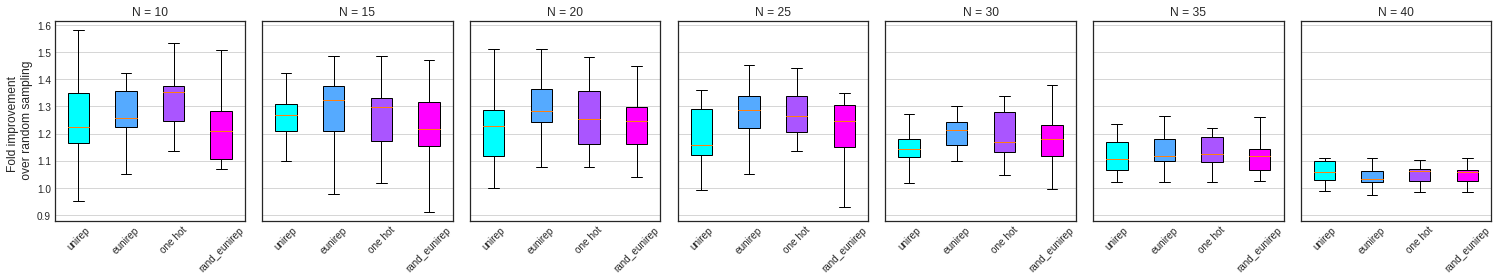

In [66]:

'''
# number of batches to test
N_BATCH = 200

# number of sequences per training batch
TRAIN_BATCH_SIZES = [10, 15,20]

# number of random trials to perform for baseline
N_RAND_BATCHES = 100
'''


# number of batches to test
N_BATCH = 20

# number of sequences per training batch
TRAIN_BATCH_SIZES = [10,15,20,25,30,35,40] 
print(TRAIN_BATCH_SIZES)
# number of random trials to perform for baseline
N_RAND_BATCHES = 100

# wild-type fitness
WT_FIT = 0.0121563


total1=len(TRAIN_BATCH_SIZES)*len(dfs)
pbar1=tqdm.notebook.tqdm(total=total1, bar_format=TQDM_BAR_FORMAT)

total2=len(TRAIN_BATCH_SIZES)*len(dfs)*N_BATCH
pbar2=tqdm.notebook.tqdm(total=total2, bar_format=TQDM_BAR_FORMAT)

total3=len(TRAIN_BATCH_SIZES)*len(dfs)*N_BATCH*N_RAND_BATCHES
pbar3=tqdm.notebook.tqdm(total=total3, bar_format=TQDM_BAR_FORMAT)

batch_level = []
for TRAIN_BATCH_SIZE in TRAIN_BATCH_SIZES:

  # number of sequences per holdout batch
  HOLDOUT_BATCH_SIZE = TRAIN_BATCH_SIZE*10

  params_level = []
  for j in range(len(dfs)):
    pbar1.update(1)
    df = dfs[j]

    scores_level = []
    for i in range(N_BATCH):
      pbar2.update(1)
      # change random seed for each batch
      np.random.seed(42*(i+2))
      rndperm = np.random.permutation(df.shape[0])

      # data setup
      X = df.loc[rndperm[0:TRAIN_BATCH_SIZE], df.columns[2:]]
      Y = df.loc[rndperm[0:TRAIN_BATCH_SIZE], "fitness"]

      X_holdout = df.loc[rndperm[TRAIN_BATCH_SIZE:TRAIN_BATCH_SIZE+HOLDOUT_BATCH_SIZE], df.columns[2:]]
      Y_holdout = df.loc[rndperm[TRAIN_BATCH_SIZE:TRAIN_BATCH_SIZE+HOLDOUT_BATCH_SIZE], "fitness"]

      # ridge regression model setup
      kfold = KFold(n_splits=10, shuffle=True)

      model = RidgeCV(alphas=[ALPHAS[j]], cv=kfold)

      # fit the model
      model.fit(X, Y)

      # use model to sort holdout set and get top TRAIN_BATCH_SIZE predicted fitness
      Y_preds = model.predict(X_holdout)

      usorted = np.array(Y_holdout)[np.argsort(Y_preds)][::-1][:int(HOLDOUT_BATCH_SIZE/10)]

      # Note: wild-type fitness = WT_FIT (thats the scoring metric)
      usorted_count = np.sum([1 if i > WT_FIT else 0 for i in usorted])

      # randomly shuffle holdout set RAND_BATCHES time
      # and take average of top TRAIN_BATCH_SIZE fitness
      avg_rand_count = 0
      for k in range(N_RAND_BATCHES):
        pbar3.update(1)
        np.random.seed(42*(i+2) + (1+k))
        rand_Y = np.random.permutation(np.array(Y_holdout))[:int(HOLDOUT_BATCH_SIZE/10)]
        avg_rand_count += np.sum([1 if i > WT_FIT else 0 for i in rand_Y])
      avg_rand_count /= N_RAND_BATCHES

      # final score ratio:
      scores_level.append(usorted_count/avg_rand_count)

    print(df_names[j], scores_level, "Mean Score:", np.mean(scores_level))
    params_level.append(scores_level)

  batch_level.append(params_level)


plt.clf()
ax_dict = {}
fig, axes = plt.subplots(nrows=1, ncols=len(TRAIN_BATCH_SIZES), sharey=True, figsize=(3*len(TRAIN_BATCH_SIZES),4))

for i in range(len(TRAIN_BATCH_SIZES)):
  ax_dict[i] = axes[i].boxplot(np.array(batch_level[i]).transpose(), showfliers=False,patch_artist=True)
  axes[i].set_title("N = "+str(TRAIN_BATCH_SIZES[i]))
  axes[i].set_xticklabels(df_names,rotation=45)
  
axes[0].set_ylabel("Fold improvement \n over random sampling",size = 12)

color_idx = np.linspace(0, 1, len(df_names))
for ax_ind in range(len(ax_dict)):
  for patch, i in zip(ax_dict[ax_ind]['boxes'], color_idx):
    patch.set_facecolor(plt.cm.cool(i))

for ax in axes:
    ax.yaxis.grid(True)

plt.tight_layout()
plt.show()

  0%|          | 0/8 [elapsed: 00:00 remaining: ?]

<Figure size 432x288 with 0 Axes>

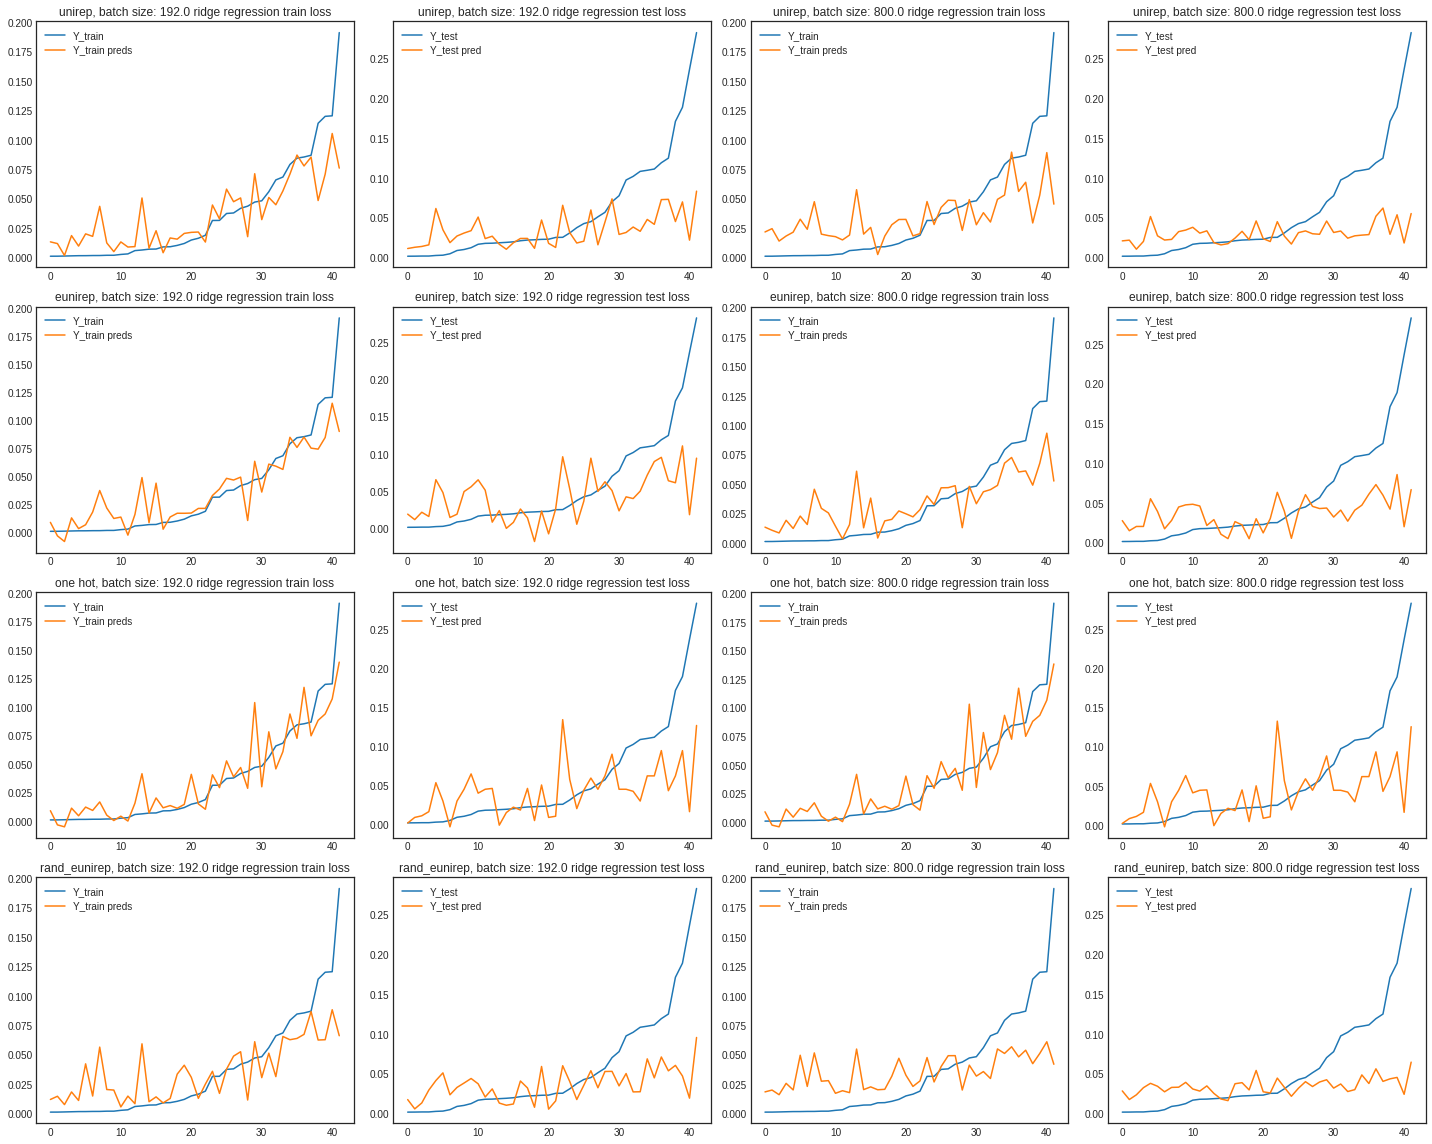

In [67]:
# Ensemble Ridge Regression
from sklearn.ensemble import BaggingRegressor
ALPHAS = [ 0.001, 0.015,1,0.001]
# ALPHAS = [ 0.0001, 0.00015,1,0.0001]

BATCH_SIZES = [96*2,800]
SPLIT = 0.5

batch_size_list = (np.array(BATCH_SIZES)/SPLIT).astype("int")

# randomly select subset of sequence as input data
np.random.seed(42)
rndperm = np.random.permutation(dfs[0].shape[0])

total=len(dfs)*len(batch_size_list)
pbar=tqdm.notebook.tqdm(total=total, bar_format=TQDM_BAR_FORMAT)

plt.clf()

fig = plt.figure(figsize=(10*len(BATCH_SIZES) ,4*len(dfs)))
plt.style.use('seaborn-white')

for i in range(len(dfs)):

  df = dfs[i]
  for j in range(len(batch_size_list)):
    pbar.update(1)
    X = df.loc[rndperm[:batch_size_list[j]], df.columns[2:]]
    Y = df.loc[rndperm[:batch_size_list[j]], "fitness"]

    # train-test split for both 
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=SPLIT, random_state=1717)

    # ridge regression model setup
    kfold = KFold(n_splits=10, random_state=1717, shuffle=True)

    model = BaggingRegressor(base_estimator=RidgeCV(alphas=[ALPHAS[j]], cv=kfold), n_estimators=20, max_samples=0.9, max_features=0.9, random_state=42)

    # fit the model
    model.fit(X_train, Y_train)

    # predict fitness to get train and test losses
    Y_train_preds = model.predict(X_train)
    Y_test_preds = model.predict(X_test)

    # train_loss = np.linalg.norm(Y_train_preds - Y_train)
    # test_loss = np.linalg.norm(Y_test_preds - Y_test)
    train_loss = np.mean((Y_train_preds - Y_train)**2)
    test_loss = np.mean((Y_test_preds - Y_test)**2)

    ax1 = fig.add_subplot(len(dfs),len(BATCH_SIZES)*2,(4*i+2*j+1), title=df_names[i] + ", batch size: " + str(batch_size_list[j]*(1-SPLIT)) + " ridge regression train loss")
    ax1.plot(np.arange(len(Y_train)), np.array(Y_train)[np.argsort(Y_train)])
    ax1.plot(np.arange(len(Y_train)), np.array(Y_train_preds)[np.argsort(Y_train)])
    ax1.legend(['Y_train','Y_train preds'])

    ax2 = fig.add_subplot(len(dfs),len(BATCH_SIZES)*2,(4*i+2*j+2), title=df_names[i] + ", batch size: " + str(batch_size_list[j]*SPLIT) + " ridge regression test loss")
    ax2.plot(np.arange(len(Y_test)), np.array(Y_test)[np.argsort(Y_test)])
    ax2.plot(np.arange(len(Y_test)), np.array(Y_test_preds)[np.argsort(Y_test)])
    ax2.legend(['Y_test','Y_test pred'])

plt.tight_layout()
plt.show()

[10, 15, 20, 25, 30, 35, 40]


  0%|          | 0/28 [elapsed: 00:00 remaining: ?]

  0%|          | 0/560 [elapsed: 00:00 remaining: ?]

  0%|          | 0/56000 [elapsed: 00:00 remaining: ?]

unirep [0.8116883116883117, 1.2066365007541477, 1.2779552715654952, 1.2232415902140672, 1.238390092879257, 1.070336391437309, 1.355421686746988, 1.228878648233487, 1.5220700152207, 1.3138686131386863, 1.109350237717908, 1.3493253373313343, 1.5797788309636651, 1.4195583596214512, 1.1730205278592374, 1.225114854517611, 1.3803680981595092, 1.1627906976744187, 1.5600624024960998, 1.1126564673157162] Mean Score: 1.2660256467767699
eunirep [0.8116883116883117, 1.3574660633484164, 1.2779552715654952, 1.2232415902140672, 1.238390092879257, 1.3761467889908257, 1.355421686746988, 1.228878648233487, 1.36986301369863, 1.4598540145985401, 1.109350237717908, 1.0494752623688155, 1.4218009478672986, 1.2618296529968454, 1.3196480938416422, 1.225114854517611, 1.2269938650306749, 1.1627906976744187, 1.4040561622464898, 1.2517385257301807] Mean Score: 1.256585189097795
one hot [1.1363636363636362, 1.3574660633484164, 1.4376996805111821, 1.2232415902140672, 1.238390092879257, 1.3761467889908257, 1.20481927

rand_eunirep [1.0106382978723405, 1.2486992715920917, 1.215644820295983, 1.1783610069630421, 1.2295081967213115, 1.1771000535045477, 1.2121212121212122, 1.0703363914373087, 1.2304779933743493, 1.2866700977869274, 0.9952854897852279, 1.2598425196850394, 1.0956175298804782, 1.2725344644750796, 1.117047110247693, 1.377848436671966, 1.2833675564681724, 1.1825922421948911, 1.256913021618904, 1.0757717492984098] Mean Score: 1.1888188730997487
unirep [1.0217113665389528, 1.0820559062218216, 1.1138014527845037, 1.1791383219954648, 1.1637931034482758, 1.0803193987787694, 1.1402027027027026, 1.0657193605683837, 1.2738853503184713, 1.2200632625395391, 1.1246063877642825, 1.0960105217010083, 1.0570824524312896, 1.1450381679389312, 1.0679196924391285, 1.2159533073929962, 1.1669658886894074, 1.0420841683366733, 1.0651896037494675, 1.0620915032679739] Mean Score: 1.1191815959804021
eunirep [1.1068539804171988, 0.9918845807033364, 1.2106537530266344, 1.1337868480725624, 1.206896551724138, 1.1742602160

<Figure size 432x288 with 0 Axes>

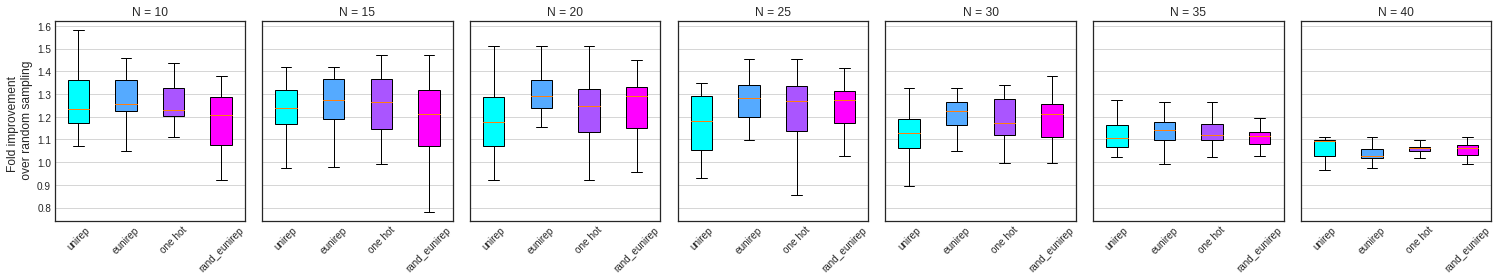

In [68]:
'''
# number of batches to test
N_BATCH = 200

# number of sequences per training batch
TRAIN_BATCH_SIZES = [10, 15,20]

# number of random trials to perform for baseline
N_RAND_BATCHES = 100
'''



# number of batches to test
N_BATCH = 20

# number of sequences per training batch
TRAIN_BATCH_SIZES = [10,15,20,25,30,35,40] 
print(TRAIN_BATCH_SIZES)
# number of random trials to perform for baseline
N_RAND_BATCHES = 100

# wild-type fitness
WT_FIT = 0.0121563


total1=len(TRAIN_BATCH_SIZES)*len(dfs)
pbar1=tqdm.notebook.tqdm(total=total1, bar_format=TQDM_BAR_FORMAT)

total2=len(TRAIN_BATCH_SIZES)*len(dfs)*N_BATCH
pbar2=tqdm.notebook.tqdm(total=total2, bar_format=TQDM_BAR_FORMAT)

total3=len(TRAIN_BATCH_SIZES)*len(dfs)*N_BATCH*N_RAND_BATCHES
pbar3=tqdm.notebook.tqdm(total=total3, bar_format=TQDM_BAR_FORMAT)



batch_level = []
for TRAIN_BATCH_SIZE in TRAIN_BATCH_SIZES:
  
  # number of sequences per holdout batch
  HOLDOUT_BATCH_SIZE = TRAIN_BATCH_SIZE*10

  params_level = []
  for j in range(len(dfs)):
    pbar1.update(1)
    df = dfs[j]

    scores_level = []
    for i in range(N_BATCH):
      pbar2.update(1)
      # change random seed for each batch
      np.random.seed(42*(i+2))
      rndperm = np.random.permutation(df.shape[0])

      # data setup
      X = df.loc[rndperm[0:TRAIN_BATCH_SIZE], df.columns[2:]]
      Y = df.loc[rndperm[0:TRAIN_BATCH_SIZE], "fitness"]

      X_holdout = df.loc[rndperm[TRAIN_BATCH_SIZE:TRAIN_BATCH_SIZE+HOLDOUT_BATCH_SIZE], df.columns[2:]]
      Y_holdout = df.loc[rndperm[TRAIN_BATCH_SIZE:TRAIN_BATCH_SIZE+HOLDOUT_BATCH_SIZE], "fitness"]

      # ridge regression model setup
      kfold = KFold(n_splits=10, shuffle=True)

      model = BaggingRegressor(base_estimator=RidgeCV(alphas=[ALPHAS[j]], cv=kfold), n_estimators=20, max_samples=0.9, max_features=0.9, random_state=42)

      # fit the model
      model.fit(X, Y)

      # use model to sort holdout set and get top TRAIN_BATCH_SIZE predicted fitness
      Y_preds = model.predict(X_holdout)

      usorted = np.array(Y_holdout)[np.argsort(Y_preds)][::-1][:int(HOLDOUT_BATCH_SIZE/10)]

      # Note: wild-type fitness = WT_FIT (thats the scoring metric)
      usorted_count = np.sum([1 if i > WT_FIT else 0 for i in usorted])

      # randomly shuffle holdout set RAND_BATCHES time
      # and take average of top TRAIN_BATCH_SIZE fitness
      avg_rand_count = 0
      for k in range(N_RAND_BATCHES):
        pbar3.update(1)
        np.random.seed(42*(i+2) + (1+k))
        rand_Y = np.random.permutation(np.array(Y_holdout))[:int(HOLDOUT_BATCH_SIZE/10)]
        avg_rand_count += np.sum([1 if i > WT_FIT else 0 for i in rand_Y])
      avg_rand_count /= N_RAND_BATCHES

      # final score ratio:
      scores_level.append(usorted_count/avg_rand_count)

    print(df_names[j], scores_level, "Mean Score:", np.mean(scores_level))
    params_level.append(scores_level)

  batch_level.append(params_level)


plt.clf()
ax_dict = {}
fig, axes = plt.subplots(nrows=1, ncols=len(TRAIN_BATCH_SIZES), sharey=True, figsize=(3*len(TRAIN_BATCH_SIZES),4))

for i in range(len(TRAIN_BATCH_SIZES)):
  ax_dict[i] = axes[i].boxplot(np.array(batch_level[i]).transpose(), showfliers=False,patch_artist=True)
  axes[i].set_title("N = "+str(TRAIN_BATCH_SIZES[i]))
  axes[i].set_xticklabels(df_names,rotation=45)
  
axes[0].set_ylabel("Fold improvement \n over random sampling",size = 12)

color_idx = np.linspace(0, 1, len(df_names))
for ax_ind in range(len(ax_dict)):
  for patch, i in zip(ax_dict[ax_ind]['boxes'], color_idx):
    patch.set_facecolor(plt.cm.cool(i))

for ax in axes:
    ax.yaxis.grid(True)

plt.tight_layout()
plt.show()

ValueError: HuberRegressor convergence failed: l-BFGS-b solver terminated with ABNORMAL_TERMINATION_IN_LNSRCH

<Figure size 432x288 with 0 Axes>

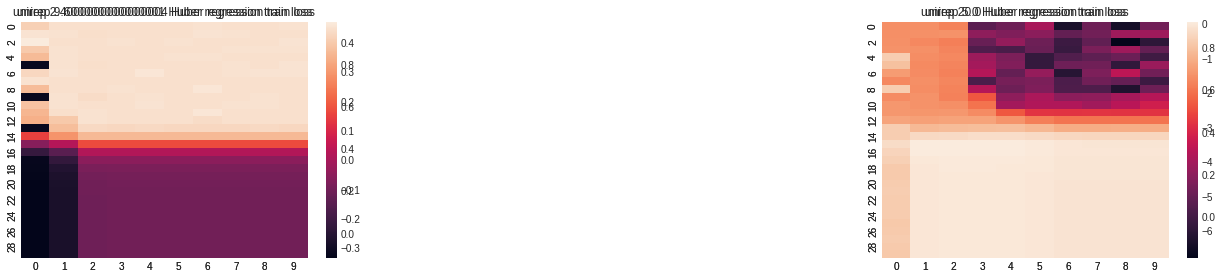

In [69]:
# HUBER LOSS
np.random.seed(42)


rndperm = np.random.permutation(unirep_df.shape[0])

BATCH_SIZES = [10,20,40]
batch_size_list = (np.array(BATCH_SIZES)/0.8).astype("int")

alpha_vals = np.logspace(-6,6,30)
eps_vals = np.linspace(1.0,5.0,10)

plt.clf()

fig = plt.figure(figsize=(45,5*len(dfs)))
plt.style.use('seaborn-white')

for i in range(len(dfs)):
  #pbar1.update(1)
  df = dfs[i]
  for j in range(len(batch_size_list)):
    #pbar2.update(1)
    X = df.loc[rndperm[:batch_size_list[j]], df.columns[2:]]
    Y = df.loc[rndperm[:batch_size_list[j]], "fitness"]


    train_loss_mat = np.zeros((len(alpha_vals), len(eps_vals)))
    test_loss_mat = np.zeros((len(alpha_vals), len(eps_vals)))

    for k in range(len(alpha_vals)):
      #pbar3.update(1)
      for l in range(len(eps_vals)):
        #pbar4.update(1)
        # train-test split for both 
        X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

        # ridge regression model setup
        kfold = KFold(n_splits=10, random_state=42, shuffle=True)
        model = HuberRegressor(epsilon=eps_vals[l], alpha=alpha_vals[k])

        # fit the model
        
        model.fit(X_train, Y_train)

        # predict fitness to get train and test losses and update matrices
        train_loss_mat[k,l] = model.score(X_train, Y_train)
        test_loss_mat[k,l] = model.score(X_test, Y_test)

    # plot train and test losses
    ax1 = fig.add_subplot(len(dfs),len(BATCH_SIZES)*2,(5*i+2*j+1), title=df_names[i] + " " + str(batch_size_list[j]*0.8) + " Huber regression train loss")
    sns.heatmap(train_loss_mat, ax=ax1)
    ax2 = fig.add_subplot(len(dfs),len(BATCH_SIZES)*2,(5*i+2*j+1), title=df_names[i] + " " + str(batch_size_list[j]*0.2) + " Huber regression train loss")
    sns.heatmap(test_loss_mat, ax=ax2)

plt.tight_layout()
plt.show()

# Direct Evolution in silico

In [70]:

from jax_unirep import get_reps, fit
# edited by Yinying
from jax_unirep.utils import load_params
from Bio import SeqIO
import pandas as pd
import glob
import os
from pathlib import Path
import numpy as np

from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import RidgeCV

import warnings
warnings.filterwarnings('ignore') 

import matplotlib.pyplot as plt
import seaborn as sns
import feather
import random

In [ ]:
def get_top_model(df, alpha, train_batch_size):

  rand_state_num = 42

  np.random.seed(rand_state_num)

  rndperm = np.random.permutation(df.shape[0])

  X_train = df.loc[rndperm[:train_batch_size], df.columns[2:]]
  Y_train = df.loc[rndperm[:train_batch_size], "fitness"]

  kfold = KFold(n_splits=10, random_state=rand_state_num, shuffle=True)

  return RidgeCV(alphas=alpha, cv=kfold).fit(X_train, Y_train)

def init_by_rep(df, alpha_val, N, param_file):

  if param_file == None:
    params = load_params(None)[1]
    DE_model = get_top_model(df, [alpha_val], N) # choose unirep representation, alpha=1e-3, and 96 training mutants


  else: # if we want to use an evotuned representation:
    params = load_params(param_file)[1]
    DE_model = get_top_model(df, [alpha_val], N) # choose eunirep representation, alpha=1e-3, and 96 training mutants

  return params, DE_model


def mutate_sequence(seq,m,prev_mut_loc): # produce a mutant sequence (integer representation), given an initial sequence and the number of mutations to introduce ("m")

  for i in range(m): #iterate through number of mutations to add
    rand_loc = random.randint(prev_mut_loc-8,prev_mut_loc+8) # find random position to mutate
    while (rand_loc <=0) or (rand_loc >= len(seq)):
      rand_loc = random.randint(prev_mut_loc-8,prev_mut_loc+8)

    rand_aa = random.randint(1,21) # find random amino acid to mutate to
    seq = list(seq)
    seq[rand_loc] = get_int_to_aa()[rand_aa] # update sequence to have new amino acid at randomely chosen position
    seq = ''.join(seq)


  return seq,rand_loc # output the randomely mutated sequence

def directed_evolution(s_wt,num_iterations,T,Model, params): # input = (wild-type sequence, number of mutation iterations, "temperature")		


  s_traj = [] # initialize an array to keep records of the protein sequences for this trajectory
  y_traj = [] # initialize an array to keep records of the fitness scores for this trajectory


  mut_loc_seed = random.randint(0,len(s_wt)) # randomely choose the location of the first mutation in the trajectory
  s,new_mut_loc = mutate_sequence(s_wt, (np.random.poisson(2) + 1),mut_loc_seed) # initial mutant sequence for this trajectory, with m = Poisson(2)+1 mutations

  x,_,_ = get_reps([s],params=params)# eUniRep representation of the initial mutant sequence for this trajectory

  y = Model.predict(x) # predicted fitness score for the initial mutant sequence for this trajectory


  # iterate through the trial mutation steps for the directed evolution trajectory
  for i in range(num_iterations):
    mu = np.random.uniform(1,2.5) # "mu" parameter for poisson function: used to control how many mutations to introduce
    m = np.random.poisson(mu-1) + 1 # how many random mutations to apply to current sequence

    s_new,new_mut_loc = mutate_sequence(s, m, new_mut_loc) # new trial sequence, produced from "m" random mutations

    x_new,_,_ = get_reps([s_new],params=params)

    y_new = Model.predict(x_new) # new fitness value for trial sequence

    p = min(1,np.exp((y_new-y)/T)) # probability function for trial sequence
    rand_var = random.random()

    if rand_var < p: # metropolis-Hastings update selection criterion
      print(str(new_mut_loc+1)+" "+s[new_mut_loc]+"->"+s_new[new_mut_loc])
      s, y = s_new, y_new # if criteria is met, update sequence and corresponding fitness

    s_traj.append(s) # update the sequence trajectory records for this iteration of mutagenesis
    y_traj.append(y) # update the fitness trajectory records for this iteration of mutagenesis


  return s_traj, y_traj # output = (sequence record for trajectory, fitness score recorf for trajectory)

def minibatches(inputs_data, batch_size):
    # fix data losing with minibatches
    for start_idx in range(0, len(inputs_data), batch_size):
        if len(inputs_data[start_idx:])>batch_size:
            excerpt = slice(start_idx, start_idx + batch_size)
            #print("yielding data len: %s" % len(inputs_data[excerpt]))
            yield inputs_data[excerpt]

        else:
            #print("yielding final data len: %s" % len(inputs_data[start_idx:]))
            yield inputs_data[start_idx:]

def run_DE_trajectories(s_wt, Model, T, num_iterations, num_trajectories, DE_record_folder,params,save=False):

  s_records = [] # initialize list of sequence records
  y_records = [] # initialize list of fitness score records

  for i in range(num_trajectories): #iterate through however many mutation trajectories we want to sample
    s_traj, y_traj = directed_evolution(s_wt,num_iterations,T,Model,params) # call the directed evolution function, outputting the trajectory sequence and fitness score records

    s_records.append(s_traj) # update the sequence trajectory records for this full mutagenesis trajectory
    y_records.append(y_traj) # update the fitness trajectory records for this full mutagenesis trajectory

    if save==True:
      # iteration_path = directory_path+"DE_records/"
      np.savetxt(DE_record_folder + "/trajectory"+str(i)+"_seqs.txt", np.array(s_traj),fmt="%s")   # save sequence records for trajectory-i
      np.savetxt(DE_record_folder + "/trajectory"+str(i)+"_fitness.txt", np.array(y_traj))   # save fitness records for trajecroty-i
    print("finished trajectory #",i)

  s_records = np.array(s_records)
  y_records = np.array(y_records)
  
  c=0
  for y_record in minibatches(y_records[:,:,0],5):
      
      plt.clf()
      fig = plt.figure(figsize=(10,6))
      plt.plot(np.transpose(y_record)) # plot the changes in fitness for all sampled trajectories
      plt.ylabel('Predicted Fitness')
      plt.xlabel('Mutation Trial Steps')
      plt.legend([f'trajectory {x}' for x in range(c*5,(c+1)*5)],fontsize=14)
      plt.savefig(f"{RES_DIR_FIGURE}/DE_{c*5+1}_{(c+1)*5}.png")
      plt.show() # show the plot :)
      #
      c+=1

  return s_records, y_records

In [76]:
seqs_df = pd.DataFrame(read_labeled_data(f"{RES_DIR_FITNESS}/P450_experi_data_encoded.csv",col_seq,col_fitness), columns = ['sequence', 'fitness'])

df = read_reps(FEATHER_PATH + 'evotuning_P450_from-_global_iter_0')

param_file=f'{RES_DIR_FEATURE}/evotuning_P450_from_global/iter_0'
print(param_file)


./results/feature/evotuning_P450_from_global/iter_0


In [135]:
alpha = 0.0015

BATCH_SIZE = 42

rand_state_num = 42

In [136]:
np.random.seed(rand_state_num)
rndperm = np.random.permutation(df.shape[0])


TRAIN_BATCH_SIZE = int(BATCH_SIZE*0.8)
HOLDOUT_BATCH_SIZE = int(BATCH_SIZE*0.2)

training_df = df.iloc[rndperm[:TRAIN_BATCH_SIZE],:]
                          
testing_df = df.iloc[rndperm[TRAIN_BATCH_SIZE:TRAIN_BATCH_SIZE+HOLDOUT_BATCH_SIZE],:]

params, DE_model = init_by_rep(df, alpha, TRAIN_BATCH_SIZE, param_file)

Train set ranking error:  0.15977961432506887
Test set ranking error:  0.15625


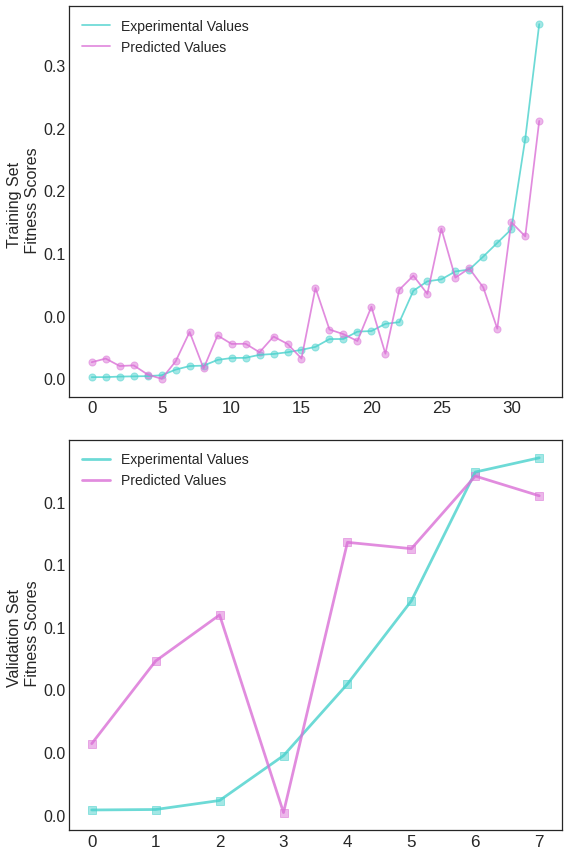

In [137]:
X_train = training_df.loc[:, training_df.columns[2:]]
Y_train = training_df.loc[:, "fitness"]
X_test = testing_df.loc[:, training_df.columns[2:]]
Y_test = testing_df.loc[:, "fitness"]


Y_train_preds = DE_model.predict(X_train)
Y_test_preds = DE_model.predict(X_test)

print("Train set ranking error: ", confusion_matrix_loss(np.array(Y_train),Y_train_preds))
print("Test set ranking error: ", confusion_matrix_loss(np.array(Y_test),Y_test_preds))


fig = plt.figure(figsize=(8,12))

ax1 = fig.add_subplot(2,1,1)
ax1.plot(np.arange(len(Y_train)), np.array(Y_train)[np.argsort(Y_train)],color='mediumturquoise',linewidth=1.75, alpha=0.8)
ax1.plot(np.arange(len(Y_train)), np.array(Y_train_preds)[np.argsort(Y_train)],color='orchid',linewidth=1.75, alpha=0.8)


ax1.scatter(np.arange(len(Y_train)), np.array(Y_train)[np.argsort(Y_train)],color='mediumturquoise',s=50, alpha=0.5)
ax1.scatter(np.arange(len(Y_train)), np.array(Y_train_preds)[np.argsort(Y_train)],color='orchid',s=50, alpha=0.5)


ax2 = fig.add_subplot(2,1,2)
ax2.plot(np.arange(len(Y_test)), np.array(Y_test)[np.argsort(Y_test)],color='mediumturquoise',linewidth=2.75, alpha=0.8)
ax2.plot(np.arange(len(Y_test)), np.array(Y_test_preds)[np.argsort(Y_test)],color='orchid',linewidth=2.75, alpha=0.8)

ax2.scatter(np.arange(len(Y_test)), np.array(Y_test)[np.argsort(Y_test)],color='mediumturquoise',s=50, alpha=0.5,marker="s")
ax2.scatter(np.arange(len(Y_test)), np.array(Y_test_preds)[np.argsort(Y_test)],color='orchid',s=50, alpha=0.5,marker="s")




ax1.set_ylabel("Training Set \n Fitness Scores",size=16)
ax2.set_ylabel("Validation Set \n Fitness Scores",size=16)


ax1.set_yticklabels(np.round(ax1.get_yticks(),1),fontsize=16)
ax2.set_yticklabels(np.round(ax2.get_yticks(),1),fontsize=16)



ax1.set_xticklabels(ax1.get_xticks().astype(int),fontsize=17)
ax2.set_xticklabels(ax2.get_xticks().astype(int),fontsize=17)


fig.tight_layout(w_pad=2.5, h_pad=2.5)

ax1.legend(['Experimental Values','Predicted Values'],fontsize=14)
ax2.legend(['Experimental Values','Predicted Values'],fontsize=14)


plt.show()

In [159]:
# define the wild-type sequence
s_wt = target_sequence


DE_record_folder = f'{RES_DIR_SEQ_OUT}/P450_DE_test' # assign project name for the simulation

os.makedirs(DE_record_folder, exist_ok=True)
T = 0.01 # "temperature" parameter: determines sensitivity of Metropolis-Hastings acceptance criteria
num_iterations = 25 # how many subsequent mutation trials per simulated evolution trajectory
num_trajectories = 10000 # how many separate evolution trajectories to run

In [ ]:
s_records, y_records = run_DE_trajectories(s_wt, DE_model, T, num_iterations, num_trajectories, DE_record_folder, params ,save=True)

152 E->D
145 E->C
144 R->C
150 R->Y
149 P->P
157 M->V
155 A->S
138 F->A
140 A->E
176 A->S
183 I->V
175 A->Y
finished trajectory # 0
268 I->E
275 Q->E
282 F->A
289 S->C
289 C->M
296 L->I
289 M->V
284 S->N
270 E->M
265 Q->I
263 Q->E
262 K->K
254 F->A
finished trajectory # 1
210 F->F
210 F->V
211 L->C
216 N->V
214 P->E
212 T->V
212 V->F
205 G->K
213 A->A
210 V->I
205 K->I
213 A->Y
209 G->A
210 I->W
210 W->L
205 I->A
finished trajectory # 2
250 I->C
250 C->W
249 K->A
243 R->G
238 D->C
235 K->D
229 T->D
229 D->D
208 G->K
205 G->M
216 N->S
213 L->D
finished trajectory # 3
56 D->P
58 H->H
59 P->Q
60 V->H
58 H->W
50 S->A
54 S->N
56 P->K
54 N->M
44 E->T
47 Q->K
45 T->Y
39 L->W
finished trajectory # 4
335 M->G
326 P->C
319 A->V
312 E->V
304 D->Y
303 P->I
305 V->S
304 Y->D
297 N->M
295 I->F
288 I->L
291 T->K
292 C->I
294 N->L
finished trajectory # 5
300 A->Y
297 N->D
299 L->G
306 V->D
302 H->N
292 M->G
296 L->I
304 D->T
308 N->A
310 E->I
299 G->N
312 E->I
327 I->T
326 P->V
323 P->H
finished traje

379 V->L
373 H->A
370 N->D
365 I->W
359 T->N
355 L->C
351 V->V
336 N->D
339 L->G
341 V->K
335 M->W
328 T->D
327 I->Q
333 K->V
345 T->Q
347 R->S
finished trajectory # 58
328 T->T
332 Y->G
315 A->N
307 K->R
307 R->D
303 P->W
311 A->Q
319 A->T
310 E->S
315 K->T
313 T->E
320 R->D
329 I->F
328 T->C
finished trajectory # 59
445 R->Q
443 K->R
448 K->E
458 H->E
460 L->A
454 I->E
453 K->E
450 D->G
453 E->R
458 E->N
459 I->I
454 E->K
448 E->H
452 I->A
449 W->Q
442 V->N
459 I->C
462 F->I
474 E->M
finished trajectory # 60
315 A->E
317 R->L
316 I->I
324 P->E
319 A->P
329 W->D
332 I->E
340 N->K
338 T->I
333 K->K
332 E->K
336 N->M
343 C->K
345 T->F
339 L->C
336 M->V
finished trajectory # 61
195 L->S
198 G->L
202 K->D
191 S->S
190 D->S
186 M->M
188 S->H
192 T->M
194 L->Y
184 V->P
187 F->M
finished trajectory # 62
432 Y->N
432 N->F
424 A->C
424 C->D
424 D->D
422 H->F
418 G->H
416 F->Y
411 K->C
404 L->L
404 L->N
409 I->P
402 K->Y
397 N->F
finished trajectory # 63
300 P->D
291 T->V
289 S->Q
283 A->Y
290 

342 I->N
343 C->S
348 L->I
354 A->W
346 G->T
354 W->K
finished trajectory # 113
322 Q->D
322 D->W
314 E->P
314 P->T
314 T->C
317 R->M
321 A->R
329 P->M
337 F->P
330 E->S
333 K->S
327 I->N
334 S->F
347 R->Q
346 L->V
finished trajectory # 114
64 K->K
64 K->D
63 R->R
55 L->A
57 V->N
55 A->Y
60 F->L
62 Q->P
63 A->V
58 D->P
63 V->S
86 D->I
70 N->K
67 R->I
61 I->F
65 V->E
finished trajectory # 115
453 K->W
445 R->E
442 T->M
433 L->V
440 L->N
448 K->Q
453 W->F
447 R->G
finished trajectory # 116
245 A->F
245 F->F
251 F->I
254 F->P
259 I->D
256 G->P
248 V->G
253 D->H
250 I->D
243 R->V
244 F->K
242 E->F
235 K->H
finished trajectory # 117
412 N->F
412 F->G
408 T->D
429 S->H
432 Y->L
424 A->E
429 H->T
430 K->I
430 I->W
432 L->G
finished trajectory # 118
413 F->R
421 R->S
429 S->G
430 K->Y
446 W->L
426 A->T
432 Y->Y
431 V->C
434 R->E
427 V->F
428 Y->I
426 T->N
finished trajectory # 119
266 Q->N
273 I->G
267 F->L
272 F->E
269 S->I
272 E->T
282 F->Q
278 F->W
275 Q->D
295 I->G
finished trajectory # 12

98 G->F
111 K->E
108 T->S
110 S->P
97 E->Q
99 M->I
106 L->N
102 E->S
105 D->P
99 I->Q
102 S->H
102 H->T
104 A->N
100 G->C
finished trajectory # 174
268 I->G
270 E->N
277 L->K
268 G->E
270 N->N
261 D->N
263 E->E
259 I->H
252 E->D
259 H->E
252 D->Y
250 I->K
248 V->D
256 G->E
264 P->H
266 M->K
finished trajectory # 175
469 N->H
465 G->R
459 S->A
466 S->K
458 H->K
465 R->A
467 P->S
464 D->C
452 G->Q
461 P->Y
456 R->L
460 W->W
458 K->D
450 K->Q
455 A->R
464 C->L
461 A->V
finished trajectory # 176
421 R->Q
435 T->Y
436 F->L
439 I->L
429 S->R
435 Y->S
447 R->W
442 T->E
441 F->S
435 S->K
finished trajectory # 177
391 K->V
389 V->T
389 T->C
392 D->E
394 D->V
407 I->Q
406 S->W
404 L->Y
finished trajectory # 178
383 R->E
388 E->D
380 T->D
381 A->T
384 H->E
380 D->I
367 G->K
358 K->M
350 S->D
349 G->G
finished trajectory # 179
61 I->R
64 S->L
48 L->V
54 S->A
57 V->T
53 D->E
57 T->M
finished trajectory # 180
320 R->D
320 D->K
323 I->T
321 A->S
319 A->F
315 A->N
309 L->M
291 T->P
299 L->C
304 D->C
3

383 R->G
379 G->C
373 G->R
372 E->P
370 I->K
371 P->D
368 Y->E
360 T->N
357 R->W
357 W->P
finished trajectory # 230
158 T->F
150 R->C
156 R->N
154 S->Y
155 A->M
148 L->M
151 I->H
141 E->P
135 L->I
137 H->F
140 A->Q
149 P->R
163 S->G
149 R->F
finished trajectory # 231
379 V->T
377 M->Y
378 L->R
372 G->M
379 I->W
380 T->W
391 K->R
384 H->L
383 R->Y
389 V->H
396 F->T
402 K->R
406 S->D
408 T->P
409 I->K
409 K->F
finished trajectory # 232
463 E->Q
455 A->N
454 I->T
449 L->T
443 K->G
450 K->T
458 H->K
457 A->A
471 T->P
459 I->V
462 F->F
441 F->F
447 R->F
finished trajectory # 233
400 R->C
397 N->N
409 I->M
417 G->F
413 F->P
412 N->P
410 Q->R
412 P->P
408 T->H
424 A->S
423 C->C
408 H->S
finished trajectory # 234
303 P->G
306 V->Y
314 E->A
320 R->Q
318 K->N
317 M->F
321 A->Q
320 Q->Q
318 N->S
320 Q->K
322 D->K
333 K->E
335 M->Q
337 F->S
340 N->T
338 T->C
finished trajectory # 235
21 N->C
19 W->S
7 G->A
7 A->M
14 A->V
11 L->F
10 T->V
7 M->T
15 Y->F
21 C->Y
9 Y->C
20 T->D
finished trajectory # 2

103 M->T
113 F->A
118 E->F
110 S->K
109 L->I
106 S->E
108 C->D
110 K->D
finished trajectory # 287
105 Y->E
98 G->N
102 E->E
83 V->R
90 N->M
89 F->F
83 R->Q
86 D->K
104 W->C
103 M->K
112 F->M
109 L->E
finished trajectory # 288
292 L->L
293 D->C
300 A->E
298 F->K
302 H->N
294 L->K
291 T->M
293 C->Y
298 K->H
finished trajectory # 289
53 D->T
61 I->I
59 P->S
54 S->S
33 P->K
37 M->A
39 L->A
54 S->C
63 R->G
finished trajectory # 290
201 K->A
206 L->L
215 L->Y
212 T->T
211 L->M
221 T->C
220 T->Q
223 H->T
227 K->P
228 D->R
220 M->K
finished trajectory # 291
223 H->L
227 K->S
220 T->N
214 P->N
214 N->Y
206 L->D
200 T->A
200 A->N
192 S->W
199 L->C
208 G->Q
208 Q->M
209 Q->H
214 C->I
218 P->T
212 H->I
216 N->M
210 R->Q
209 H->T
214 I->T
207 L->E
finished trajectory # 292
107 D->H
102 E->V
109 L->I
114 G->M
113 F->F
120 L->H
112 F->T
110 Y->S
113 F->S
85 T->S
83 V->S
78 G->T
71 I->V
78 T->G
81 V->I
finished trajectory # 293
255 L->C
256 G->Y
243 R->P
238 D->H
234 K->K
231 Q->P
242 E->D
231 P->F
fi

349 G->W
361 S->Q
364 H->M
366 K->E
363 I->D
370 I->Q
finished trajectory # 345
51 P->V
47 Q->D
51 V->G
44 E->H
49 S->V
57 V->I
72 F->Y
77 A->F
77 F->C
70 G->M
finished trajectory # 346
327 I->Q
324 D->K
333 K->N
331 E->Q
335 M->Q
336 N->Q
333 N->S
340 N->P
331 Q->I
330 T->R
331 I->I
323 P->R
325 G->K
333 S->N
335 Q->A
339 L->W
339 W->E
finished trajectory # 347
215 L->T
219 G->R
223 H->V
229 M->N
232 I->P
225 C->K
218 P->K
212 T->G
220 D->I
finished trajectory # 348
8 L->Y
finished trajectory # 349
292 Y->V
306 V->Y
312 E->E
310 E->Y
315 A->I
335 M->W
327 I->Q
332 Y->V
329 W->D
321 A->I
317 R->T
321 I->P
325 G->G
finished trajectory # 350
160 H->Y
158 S->I
155 A->I
166 T->M
167 S->C
166 M->Y
166 Y->D
155 I->F
149 P->L
148 L->G
144 R->I
154 G->D
148 G->G
finished trajectory # 351
127 H->H
133 I->F
134 T->A
125 L->Q
123 L->P
133 F->Y
129 P->D
121 V->L
120 L->H
128 M->I
135 S->H
137 H->H
137 H->Y
finished trajectory # 352
108 T->R
102 E->K
102 K->A
106 T->Y
109 L->C
114 G->N
119 W->T
122

300 A->H
finished trajectory # 403
173 S->P
168 Q->Y
154 S->T
150 R->E
145 E->E
149 P->N
157 E->P
172 E->R
166 T->D
164 T->C
178 V->I
177 M->L
183 I->Q
finished trajectory # 404
291 T->W
293 T->I
285 F->W
295 S->F
299 L->F
306 V->N
306 N->T
301 G->P
305 V->F
310 E->W
finished trajectory # 405
220 T->P
214 V->Q
207 L->A
211 L->F
217 L->H
210 F->M
206 L->T
198 G->K
195 L->V
191 S->A
199 L->T
193 G->A
finished trajectory # 406
195 L->G
194 K->D
189 E->L
178 V->C
184 V->V
196 T->Q
203 F->Y
208 G->A
208 A->M
203 Y->Y
199 L->D
206 F->G
206 G->A
198 K->A
193 W->L
200 T->Y
204 T->P
200 Y->M
finished trajectory # 407
224 N->S
231 Q->H
236 L->K
233 Q->F
233 F->Q
231 H->Q
221 T->L
223 H->R
221 L->Q
221 Q->G
238 D->T
237 K->R
249 K->Q
finished trajectory # 408
81 V->D
87 A->R
77 A->I
82 K->V
75 C->C
78 G->W
67 R->W
74 T->H
84 S->F
93 I->D
finished trajectory # 409
8 A->G
9 T->G
8 G->P
12 A->T
7 G->K
2 W->T
5 G->Y
3 S->L
8 P->P
13 I->I
17 W->Y
29 N->N
27 K->N
finished trajectory # 410
419 G->P
427 

447 C->F
439 N->E
437 S->W
421 R->S
424 A->M
409 I->I
393 P->H
383 R->Y
376 V->I
381 A->D
376 I->C
377 M->E
371 P->R
finished trajectory # 470
341 V->S
346 L->V
340 N->D
335 M->M
338 T->N
341 S->R
345 T->E
350 S->P
346 V->N
348 F->E
347 R->S
365 I->G
365 G->G
364 I->Y
365 G->K
367 G->L
finished trajectory # 471
410 Q->K
414 M->F
414 F->D
415 P->A
414 D->F
407 I->Y
393 P->D
385 R->K
381 A->R
387 P->H
395 T->T
395 T->F
404 L->F
404 F->W
402 K->V
403 E->Q
finished trajectory # 472
167 S->E
172 E->C
164 K->D
166 T->T
167 E->D
165 Q->K
165 K->E
168 V->Y
170 V->V
finished trajectory # 473
423 C->S
432 Y->L
430 K->Q
423 S->G
417 G->C
415 P->M
414 M->T
397 N->S
393 P->A
finished trajectory # 474
14 A->I
7 G->H
12 A->F
10 E->I
13 I->F
2 K->W
6 L->A
3 T->H
13 F->S
3 H->D
16 Y->S
16 S->N
11 L->M
finished trajectory # 475
287 S->T
293 T->A
287 T->E
283 A->V
288 I->Q
283 V->K
278 F->K
277 U->H
273 I->H
271 E->G
267 F->S
261 D->F
261 F->L
258 A->S
258 S->W
257 Q->K
finished trajectory # 476
139 G->F

26 S->F
30 G->Y
30 Y->G
24 K->N
32 L->L
34 P->N
39 L->C
finished trajectory # 527
421 R->G
421 G->W
421 W->Y
431 V->I
429 S->S
430 K->F
433 F->L
441 F->A
449 L->I
450 K->R
456 R->K
452 G->N
458 H->A
465 G->A
461 N->Y
463 E->V
finished trajectory # 528
115 L->M
111 K->F
115 M->P
114 G->T
109 L->M
117 T->H
131 R->I
136 N->R
136 R->S
129 Y->H
122 P->N
116 D->P
124 P->C
123 L->S
121 K->D
finished trajectory # 529
365 I->R
376 V->G
381 A->N
382 D->A
381 N->K
382 A->A
384 H->M
379 V->V
380 T->Q
377 M->F
373 G->Q
380 Q->E
377 F->Y
382 A->L
377 Y->L
371 P->D
finished trajectory # 530
132 S->C
120 L->S
114 G->R
118 E->Y
118 Y->V
124 G->H
118 V->T
109 L->N
97 E->E
finished trajectory # 531
122 A->H
128 K->Y
122 H->M
121 K->R
127 H->L
122 M->E
115 T->F
116 D->D
115 F->G
110 S->W
114 G->M
121 R->Q
118 E->Q
112 W->A
102 E->H
finished trajectory # 532
450 K->H
445 R->E
450 H->C
458 H->Q
469 N->V
463 E->S
468 V->I
474 E->N
474 N->T
473 K->T
472 P->R
466 L->C
464 D->E
460 P->F
467 E->F
finished trajec

288 I->A
284 S->V
285 K->I
278 F->R
274 I->N
finished trajectory # 583
434 C->S
430 K->S
419 G->N
417 G->K
422 H->W
417 K->T
415 P->G
415 G->Q
398 P->W
finished trajectory # 584
116 D->W
123 L->Q
119 L->I
112 F->W
108 T->A
111 K->K
111 K->H
103 M->D
98 G->N
99 R->S
103 D->G
104 W->W
110 S->N
99 S->K
finished trajectory # 585
256 G->D
275 Q->G
281 S->E
289 S->M
295 I->D
281 E->F
286 E->Q
289 M->N
284 S->A
291 T->Q
282 F->A
270 E->M
finished trajectory # 586
28 F->F
31 H->Y
51 P->M
38 G->G
32 L->R
32 R->L
40 P->P
46 I->I
64 K->H
finished trajectory # 587
357 R->M
359 F->I
359 I->D
367 G->P
360 T->M
368 Y->C
364 Q->A
365 I->E
360 M->D
359 D->Q
355 L->I
350 S->N
340 N->V
339 L->A
341 V->S
346 L->W
348 L->Y
finished trajectory # 588
339 L->T
332 Y->R
333 K->L
337 U->R
330 Y->P
338 T->S
332 R->F
331 E->Q
337 P->S
330 P->N
330 N->P
328 N->D
338 S->Q
321 A->Q
318 K->E
315 A->K
308 E->Q
301 D->I
finished trajectory # 589
301 K->A
300 A->P
287 S->W
284 S->G
287 W->W
276 L->I
277 L->M
292 L->V
30

223 H->S
217 L->L
219 G->G
218 P->L
223 S->M
219 G->F
224 K->G
220 I->V
231 Q->G
239 I->P
246 K->T
239 P->P
240 L->I
236 L->F
finished trajectory # 644
443 K->V
441 F->W
447 R->W
439 I->H
434 C->F
434 F->V
448 K->K
454 I->M
461 R->M
466 L->K
469 N->R
466 K->M
471 T->L
472 M->L
470 H->W
471 L->W
finished trajectory # 645
140 A->M
136 N->T
134 T->E
124 G->S
131 R->C
136 T->M
131 C->Q
134 E->T
140 M->M
146 R->H
154 S->M
148 L->H
finished trajectory # 646
173 S->G
165 Q->Y
158 T->M
158 M->E
166 T->F
160 H->H
158 E->R
155 A->F
160 L->A
148 L->E
150 T->G
156 R->N
159 L->H
159 H->G
167 S->F
165 R->L
165 L->N
164 Y->F
157 E->E
160 Y->H
153 K->Q
145 E->R
144 R->I
finished trajectory # 647
270 E->V
272 K->Q
261 D->Y
258 A->G
257 Q->Q
268 I->N
272 Q->S
270 V->E
267 F->R
261 Y->N
258 G->N
265 Q->L
finished trajectory # 648
413 F->A
411 K->F
398 P->G
397 N->F
389 V->I
388 E->L
398 G->K
393 P->R
388 L->F
387 P->D
379 V->E
381 A->W
385 R->I
finished trajectory # 649
251 D->N
246 K->H
242 E->T
236 L->

66 K->E
75 N->Q
74 T->W
76 W->K
finished trajectory # 699
52 S->S
54 S->C
64 K->G
68 Y->L
61 I->E
53 K->H
53 H->N
47 Q->Q
54 C->V
59 P->A
59 A->E
62 Q->Q
56 S->Y
54 V->V
finished trajectory # 700
220 T->C
226 I->D
231 Q->R
216 N->D
223 H->F
228 D->D
224 Q->E
232 I->A
222 S->P
226 D->F
227 K->K
218 S->C
216 D->H
220 C->G
finished trajectory # 701
91 H->L
90 N->I
90 I->M
100 A->D
98 G->K
102 E->N
109 L->M
116 D->E
108 T->V
112 F->A
112 A->E
100 R->W
finished trajectory # 702
19 W->Y
16 Y->D
23 W->L
39 L->V
46 I->F
33 P->S
30 G->E
31 H->F
26 S->F
21 I->K
29 N->S
29 S->N
27 K->F
31 F->F
24 Y->M
24 M->S
finished trajectory # 703
328 T->V
325 G->W
325 W->G
323 P->Y
325 G->N
333 T->Q
327 I->C
328 V->Y
321 A->V
316 I->Y
316 Y->R
316 R->T
323 Y->A
finished trajectory # 704
327 I->S
319 A->E
302 H->E
296 L->D
304 D->I
315 A->A
307 K->T
301 P->Q
305 V->L
300 A->Y
finished trajectory # 705
75 C->Y
69 G->M
74 T->N
72 U->U
83 V->E
101 V->M
108 T->Y
108 Y->M
122 A->H
129 Y->F
128 K->T
127 H->N
131 R-

364 C->S
365 I->Q
368 Y->L
369 E->W
376 V->W
372 E->M
380 T->Q
382 S->G
379 V->Q
387 P->I
388 W->I
389 V->G
395 T->Q
393 P->N
397 N->R
finished trajectory # 757
293 I->V
299 L->W
294 L->A
287 S->R
279 S->C
267 F->Q
260 K->K
261 D->T
259 I->K
260 K->V
256 G->P
250 I->G
247 G->D
248 V->Y
256 P->I
finished trajectory # 758
300 A->L
298 F->D
305 V->Y
317 R->H
315 A->G
321 A->D
310 E->V
317 H->Y
317 Y->Q
331 E->F
328 T->A
328 A->S
330 E->E
325 G->T
339 L->I
finished trajectory # 759
262 K->V
256 G->Q
270 T->N
269 S->P
274 I->I
272 F->E
261 D->E
245 A->W
240 L->W
247 G->G
244 L->V
244 V->A
241 C->V
241 V->W
251 D->L
248 V->N
250 I->D
finished trajectory # 760
216 N->T
228 D->N
234 K->E
233 Q->F
244 L->L
241 E->I
241 I->I
247 G->Q
249 K->K
250 I->N
249 K->A
245 A->Q
244 L->E
245 Q->D
252 M->K
252 K->N
250 N->V
255 M->C
finished trajectory # 761
460 L->M
457 A->E
452 G->H
458 H->T
447 R->H
453 K->S
450 K->C
422 H->F
finished trajectory # 762
172 E->N
158 T->D
150 R->P
143 L->N
144 R->S
149 P->

142 S->M
142 M->T
150 R->P
154 S->H
152 E->E
148 L->V
148 V->C
144 D->H
137 H->L
139 G->V
150 T->K
155 A->A
finished trajectory # 813
33 P->V
26 S->V
25 D->E
28 Q->T
27 K->I
28 T->S
28 S->E
26 V->N
31 V->T
30 G->W
22 K->K
28 E->M
27 I->K
finished trajectory # 814
23 S->W
37 M->E
38 F->H
53 D->V
61 I->M
69 G->H
61 M->M
63 E->D
56 D->R
55 L->G
60 F->T
61 I->W
69 H->T
66 K->F
finished trajectory # 815
41 L->G
47 U->A
53 D->I
50 R->P
47 A->P
52 S->W
50 I->Y
68 Y->K
69 G->W
67 R->A
64 K->F
67 A->E
63 H->D
68 K->Y
64 F->W
69 W->M
75 C->R
finished trajectory # 816
449 L->E
441 F->Q
438 H->Y
452 G->I
446 W->V
441 Q->W
439 I->F
432 Y->Y
432 Y->H
436 F->F
425 G->L
420 L->P
416 F->N
426 A->H
finished trajectory # 817
215 L->F
206 L->V
211 L->K
205 G->V
212 T->H
207 V->S
201 K->R
209 G->G
217 L->Q
225 C->R
239 I->C
235 K->M
243 R->S
finished trajectory # 818
369 T->R
372 E->P
375 T->E
372 P->P
371 P->I
369 R->D
372 P->S
378 N->F
374 W->Y
374 Y->P
379 V->C
393 P->H
397 N->T
402 K->L
407 I->E
414 M-

154 S->P
153 E->E
148 L->S
148 S->E
150 R->A
151 I->A
158 T->V
158 V->R
150 F->L
142 S->E
141 E->M
137 H->W
133 I->Q
135 C->K
129 Y->H
finished trajectory # 869
166 T->P
177 M->G
185 K->K
185 K->N
179 F->S
179 S->L
181 T->L
183 I->T
189 E->E
196 T->L
207 L->R
214 P->I
211 L->F
finished trajectory # 870
374 W->P
373 G->A
377 N->R
371 P->H
385 R->P
384 H->Q
379 U->N
375 M->D
376 V->P
371 H->M
369 T->E
373 A->K
367 G->S
363 I->W
366 K->H
376 P->N
371 M->C
finished trajectory # 871
150 T->G
143 U->S
128 K->D
126 I->L
134 T->W
136 N->N
finished trajectory # 872
392 D->H
404 L->Q
407 I->G
408 T->L
423 C->T
428 Y->L
431 V->V
426 I->F
436 F->I
438 H->R
442 T->W
434 C->W
442 W->T
finished trajectory # 873
457 U->I
449 Q->V
447 R->L
455 W->Q
462 F->F
453 N->H
435 T->F
438 H->D
431 V->A
435 F->I
432 Y->F
finished trajectory # 874
316 I->I
322 D->N
321 A->K
314 E->R
320 R->P
323 I->C
329 W->K
335 M->N
342 I->I
334 S->E
299 L->T
295 I->F
finished trajectory # 875
330 E->T
336 N->N
341 V->M
337 F->Q

442 T->K
439 Q->V
441 F->H
417 G->D
419 G->L
421 R->Y
finished trajectory # 933
42 I->S
47 Q->H
46 I->F
36 T->Q
47 H->P
finished trajectory # 934
426 A->S
434 C->T
429 S->Q
424 A->E
428 Y->Y
427 E->D
431 V->H
416 F->I
408 H->I
413 F->E
411 K->F
408 I->T
400 R->L
408 T->S
402 K->M
410 K->D
421 S->H
finished trajectory # 935
465 G->E
467 Y->Y
460 L->L
445 R->Y
453 K->V
461 R->W
453 V->H
445 Y->C
441 F->H
433 G->T
431 V->M
432 Y->E
427 E->K
finished trajectory # 936
170 V->V
172 E->K
183 I->N
189 E->S
194 L->K
191 S->C
194 K->R
193 K->T
201 K->T
203 F->D
199 L->N
205 G->Y
finished trajectory # 937
150 Q->G
156 R->F
154 S->Q
153 E->S
157 E->Q
161 Y->K
155 A->H
142 S->I
139 G->R
136 N->Q
139 R->T
147 F->Y
155 T->M
153 S->K
148 T->T
143 L->Q
finished trajectory # 938
321 A->D
319 A->W
318 K->A
319 W->R
317 R->F
314 E->Y
321 D->G
316 K->M
315 A->A
318 A->E
318 E->S
326 P->S
332 Y->F
330 E->E
finished trajectory # 939
46 I->W
40 P->Q
52 V->D
58 H->F
62 Q->P
66 K->M
73 K->S
80 P->W
72 F->H
67 R

421 R->L
408 T->E
405 D->S
400 R->E
403 E->K
411 K->D
411 D->S
404 L->L
413 F->S
finished trajectory # 992
258 A->K
256 G->Y
254 F->M
248 V->P
252 E->S
240 L->S
232 I->G
236 L->Y
237 K->R
235 K->T
240 C->E
234 K->F
230 K->T
238 D->I
242 E->L
247 G->H
finished trajectory # 993
261 D->L
250 I->G
232 I->A
228 D->C
220 T->A
234 K->H
222 Y->W
finished trajectory # 994
155 A->H
157 E->K
154 S->I
142 S->H
136 N->V
143 L->L
150 R->K
150 K->S
143 L->C
135 L->S
155 H->R
148 Y->F
149 P->W
154 I->L
158 T->L
161 P->C
finished trajectory # 995
342 I->H
348 L->M
356 L->K
351 V->K
354 A->W
351 K->Y
359 T->M
356 K->V
363 I->A
361 K->Q
372 E->N
365 I->P
360 T->M
363 A->M
355 L->C
finished trajectory # 996
398 Y->A
397 A->P
388 E->N
381 A->W
379 V->S
389 V->V
397 P->N
398 A->Q
403 E->R
387 T->K
379 S->Y
380 T->K
finished trajectory # 997
17 I->L
32 L->K
24 K->E
5 L->G
6 L->N
22 K->C
16 Y->E
finished trajectory # 998
85 T->D
81 F->G
88 E->G
93 I->T
94 M->L
100 A->W
88 G->Y
73 K->K
69 G->S
75 C->V
70 P->S


16 Y->H
24 Q->H
31 V->T
42 I->H
41 L->L
finished trajectory # 1049
293 T->A
289 S->Y
283 K->G
271 E->K
267 F->S
260 K->K
252 E->L
248 V->L
241 E->N
233 Q->S
231 Q->Q
232 I->Q
242 E->F
245 A->F
finished trajectory # 1050
323 P->F
328 T->I
329 W->P
325 G->I
318 C->R
319 A->M
330 S->S
337 F->C
340 N->Q
334 S->A
342 I->H
342 H->E
340 Q->M
336 N->I
333 K->I
336 I->P
343 L->W
350 S->V
finished trajectory # 1051
190 D->K
184 V->P
192 S->M
199 L->K
213 L->Y
214 P->Q
220 T->R
221 T->I
219 G->P
216 N->N
223 H->Q
205 G->R
198 F->G
198 G->S
finished trajectory # 1052
64 K->R
74 T->L
81 V->I
78 G->M
80 P->F
85 T->Q
90 N->S
112 F->C
114 G->F
129 Y->H
128 K->G
133 I->D
finished trajectory # 1053
175 A->A
164 T->L
158 T->E
164 L->H
157 E->S
152 E->K
149 P->V
148 L->W
155 A->F
165 Q->K
172 E->G
finished trajectory # 1054
102 E->C
104 W->T
95 L->A
103 A->Y
99 R->N
93 I->C
98 G->Q
95 A->T
97 E->T
111 K->Q
113 F->W
finished trajectory # 1055
361 K->K
353 P->Q
346 L->I
343 C->A
340 N->R
353 V->G
349 G->V
3

147 F->V
150 V->H
155 A->L
141 K->Y
140 A->S
134 T->T
finished trajectory # 1104
235 K->I
235 I->F
232 I->M
224 K->K
229 F->E
232 M->V
229 I->Q
234 K->D
221 T->W
214 P->G
207 L->Q
205 G->Q
203 F->M
209 G->P
215 L->M
223 H->N
finished trajectory # 1105
239 Q->K
235 K->N
242 E->D
239 K->Y
238 D->D
236 K->W
239 Y->Y
245 A->A
229 M->H
229 H->K
230 M->K
221 T->A
212 T->A
215 L->W
213 L->R
finished trajectory # 1106
51 P->I
42 I->H
53 D->E
67 R->S
63 R->T
65 F->W
69 G->Y
65 W->W
60 F->T
67 S->K
69 T->R
finished trajectory # 1107
245 A->K
249 K->M
248 V->A
254 F->T
257 Q->L
253 D->R
247 G->Q
255 L->W
254 D->D
253 R->S
246 K->A
245 K->D
244 L->T
244 T->P
242 E->P
240 L->L
238 D->M
finished trajectory # 1108
324 D->T
329 W->I
326 P->C
332 Y->P
330 E->V
326 P->Q
325 G->D
318 K->K
324 T->K
331 E->N
337 F->K
345 T->Y
351 V->Y
353 P->F
360 T->Y
367 G->I
363 I->F
361 K->E
364 Q->P
357 R->C
357 C->G
370 I->G
finished trajectory # 1109
96 Q->P
81 V->N
80 P->K
78 G->E
82 V->Y
80 K->L
77 A->V
71 I->T
59

335 M->K
329 R->T
322 T->N
314 E->D
321 S->Q
326 K->S
330 Q->V
336 F->S
334 S->V
finished trajectory # 1159
32 L->N
32 N->Y
37 M->V
finished trajectory # 1160
161 A->Q
165 Q->Q
139 G->D
134 T->T
134 T->S
134 S->M
150 R->T
142 E->V
144 R->C
149 P->S
144 C->R
150 Q->Q
finished trajectory # 1161
358 K->M
358 M->L
374 W->R
381 A->N
382 S->K
379 V->Q
386 D->L
387 P->I
382 K->E
382 E->W
376 V->Q
370 L->H
372 E->G
367 G->E
360 T->Q
367 E->D
359 T->N
358 L->Y
361 C->W
finished trajectory # 1162
429 W->G
425 G->H
428 Y->F
434 C->E
442 H->E
442 E->Q
441 G->T
438 H->N
429 G->T
417 G->M
441 T->R
finished trajectory # 1163
110 S->L
112 F->E
107 D->Q
109 W->W
106 L->W
100 A->M
92 Y->V
91 H->G
100 M->T
102 E->K
95 L->K
98 L->H
100 T->L
108 R->A
110 L->K
113 F->G
finished trajectory # 1164
153 E->Q
146 R->C
140 A->Y
146 C->W
116 D->H
100 A->Y
106 L->F
108 T->Q
103 M->D
115 L->G
finished trajectory # 1165
156 R->H
158 T->F
152 E->M
145 E->N
133 I->S
136 N->R
137 H->V
126 I->D
126 D->V
119 W->G
112 F->F

218 P->T
224 K->S
226 I->G
224 S->L
234 K->M
finished trajectory # 1216
351 E->E
344 E->F
345 T->L
347 R->D
350 S->G
352 Y->C
344 F->N
352 C->I
356 L->W
358 E->D
363 I->Y
374 W->A
379 V->R
373 G->G
371 F->N
366 K->K
362 E->E
355 L->N
finished trajectory # 1217
86 D->Y
82 V->F
80 P->P
83 V->S
81 V->R
75 E->L
75 L->V
75 V->T
75 T->E
76 L->E
77 A->D
73 K->R
69 G->K
66 K->R
62 Q->Y
finished trajectory # 1218
376 V->E
375 T->I
367 G->G
358 K->N
367 G->R
368 Y->E
364 Q->Y
354 A->P
346 L->N
340 N->S
338 T->N
331 E->V
332 Y->H
326 P->H
323 P->I
finished trajectory # 1219
134 T->W
129 Y->P
123 L->Q
136 N->T
138 F->P
139 Y->T
141 E->G
129 P->F
146 V->V
148 L->Y
161 Y->K
159 L->Y
finished trajectory # 1220
91 V->K
85 T->A
81 V->Y
80 E->K
85 A->Y
80 K->V
77 A->L
83 V->I
80 V->E
74 T->T
67 R->A
67 A->I
64 K->P
63 R->Q
69 G->R
73 K->Y
finished trajectory # 1221
260 K->R
261 D->L
260 R->G
274 I->Y
278 F->D
276 L->S
282 F->F
275 Q->E
274 Y->H
275 E->T
282 F->L
281 S->S
285 F->Y
282 L->S
284 S->F
finis

283 A->P
279 S->G
285 F->L
290 T->E
293 T->S
288 I->C
287 S->S
298 F->Y
306 V->L
303 P->N
298 Y->D
299 L->L
finished trajectory # 1273
139 G->G
142 S->P
138 F->R
142 P->S
133 I->D
139 G->Y
121 K->M
114 G->K
113 F->D
108 T->D
109 L->T
117 T->V
112 F->F
finished trajectory # 1274
287 S->I
291 A->S
294 L->Q
300 A->R
308 E->Q
308 Q->D
306 V->K
315 A->M
308 D->T
304 D->N
307 K->Y
308 T->N
316 I->I
323 P->D
finished trajectory # 1275
247 G->N
243 M->E
251 D->T
258 A->M
259 I->H
256 G->G
269 S->Q
262 K->E
251 T->Y
259 H->E
finished trajectory # 1276
119 W->E
111 K->R
116 D->S
114 G->G
116 S->Y
106 L->H
109 F->S
97 E->P
96 Q->N
97 P->P
finished trajectory # 1277
311 A->D
315 A->G
315 G->Q
307 K->E
292 L->M
278 F->D
278 D->E
288 I->M
finished trajectory # 1278
94 M->Q
96 Q->L
96 L->W
95 L->I
92 Y->Q
78 G->N
72 F->C
66 K->N
74 T->T
70 P->Y
finished trajectory # 1279
79 R->V
77 A->R
78 S->P
86 D->T
94 M->Q
80 W->D
107 D->D
99 R->G
96 Q->S
97 E->Y
finished trajectory # 1280
254 F->W
256 G->E
261 D

419 G->Q
424 A->W
416 F->C
413 F->F
417 I->L
414 M->T
410 Q->G
404 L->N
405 D->K
405 K->E
415 P->E
finished trajectory # 1332
322 D->D
327 I->P
332 Y->R
334 S->M
335 M->G
337 F->S
341 V->R
347 R->F
366 K->F
360 T->Q
362 E->W
355 L->D
356 L->M
348 L->H
352 T->Q
350 S->F
finished trajectory # 1333
63 R->H
55 L->E
62 T->S
65 V->Q
71 I->M
66 K->M
59 P->R
67 R->I
62 S->M
64 K->M
60 F->Y
63 H->H
63 H->H
finished trajectory # 1334
172 E->D
158 T->W
152 E->F
156 R->R
149 P->N
138 F->F
140 A->W
139 G->I
143 P->S
150 R->W
158 W->E
164 T->R
155 A->A
159 L->E
161 E->H
168 V->F
finished trajectory # 1335
284 S->P
289 S->N
291 T->D
299 L->C
293 T->I
290 M->V
284 P->V
293 I->S
289 N->N
295 I->I
302 H->G
311 A->Y
311 Y->T
finished trajectory # 1336
156 R->V
163 S->N
175 A->G
172 E->N
174 A->T
177 M->L
179 F->C
172 N->A
175 G->Q
173 K->D
178 V->N
174 T->A
185 K->S
finished trajectory # 1337
232 I->P
233 Q->N
245 A->I
238 D->W
245 I->Q
252 E->R
259 I->W
261 D->Y
269 S->P
264 S->W
263 E->N
255 L->D
248 V

87 A->Q
90 I->W
90 W->W
finished trajectory # 1387
465 G->R
469 N->R
462 F->V
458 H->C
460 L->H
468 V->W
462 V->S
466 L->D
467 Y->R
464 Y->K
466 H->N
468 D->A
466 N->G
471 F->Y
469 R->P
470 D->K
471 Y->S
466 R->Q
467 K->N
462 S->L
finished trajectory # 1388
373 M->P
379 V->W
378 L->I
380 T->T
374 W->D
364 Q->E
367 G->V
373 P->A
367 V->W
363 I->H
364 E->I
367 W->Q
374 D->Q
366 V->R
365 K->W
358 K->P
finished trajectory # 1389
113 F->M
112 Q->T
118 E->S
107 D->V
107 V->L
115 L->D
113 M->L
113 L->K
113 K->K
114 G->H
108 T->E
109 L->A
114 H->H
106 L->A
105 Y->A
finished trajectory # 1390
150 R->V
143 E->G
141 E->N
150 V->T
142 C->W
139 G->E
152 E->N
148 L->E
141 N->D
144 R->G
136 N->W
129 Y->Q
125 L->G
finished trajectory # 1391
13 I->N
21 N->Q
14 A->F
17 I->R
21 Q->A
24 K->Q
17 R->R
11 R->K
14 F->W
25 D->M
36 T->D
finished trajectory # 1392
435 M->T
445 R->K
437 L->L
443 K->T
442 T->F
434 C->D
426 A->T
418 G->W
411 K->S
415 P->I
417 G->E
409 I->G
409 G->K
410 Q->Y
414 M->I
finished trajec

196 T->Q
204 V->K
207 K->T
204 K->C
finished trajectory # 1444
184 V->C
176 A->P
173 S->I
173 I->D
175 A->T
183 I->L
189 E->P
169 E->H
161 Y->W
156 R->R
160 H->F
finished trajectory # 1445
80 W->W
75 C->C
69 G->L
64 K->A
68 Y->N
76 F->T
75 C->H
84 N->F
88 E->Y
100 A->P
100 P->K
103 M->I
110 S->S
113 F->K
finished trajectory # 1446
443 Y->G
433 L->M
431 V->D
434 C->K
435 F->H
443 G->K
444 Y->E
436 F->M
438 H->L
435 H->S
438 L->I
442 T->Q
448 U->I
454 I->L
458 H->V
461 K->Q
460 L->W
finished trajectory # 1447
383 R->T
384 H->T
381 A->H
383 T->D
389 V->G
391 K->E
395 T->T
394 D->M
389 G->P
397 N->D
393 P->N
finished trajectory # 1448
69 G->Y
61 I->Y
74 H->G
75 C->S
83 V->I
88 E->Q
85 T->Q
76 L->K
67 R->D
75 S->E
finished trajectory # 1449
189 E->G
184 V->H
185 K->P
190 C->D
203 F->A
194 L->H
198 G->P
214 P->S
209 G->S
211 V->V
202 K->Y
210 F->V
217 L->T
225 C->E
finished trajectory # 1450
83 V->E
76 L->Y
83 S->W
84 S->M
91 H->R
91 R->C
91 C->H
85 N->N
84 M->N
finished trajectory # 1451
35

188 S->Y
176 A->F
168 V->T
163 S->I
176 F->N
158 T->D
153 E->I
150 R->Q
157 E->E
161 Y->S
finished trajectory # 1502
149 P->V
147 F->H
147 H->W
156 R->A
148 K->L
146 R->F
156 A->Y
158 T->Y
finished trajectory # 1503
402 K->C
398 N->I
402 C->Q
396 M->V
392 D->R
409 I->R
417 G->S
422 H->T
436 F->M
435 T->V
443 K->R
444 Y->R
446 W->Y
442 T->V
448 K->E
455 A->A
457 A->A
458 H->T
finished trajectory # 1504
239 I->D
234 K->L
237 K->A
240 L->R
234 L->T
221 T->T
223 H->Q
221 T->C
223 Q->S
215 L->H
finished trajectory # 1505
364 Q->I
359 T->E
355 L->W
363 I->Q
370 I->I
365 I->R
357 R->V
350 S->D
345 T->E
352 T->A
352 A->E
352 E->L
370 I->Y
364 I->A
366 K->V
376 N->Q
376 Q->S
368 Y->T
finished trajectory # 1506
25 D->R
36 T->Q
47 Q->L
41 L->N
47 L->H
finished trajectory # 1507
469 D->G
464 D->S
464 S->G
471 Y->F
462 F->T
462 T->M
466 L->E
472 P->S
466 E->F
458 H->E
460 L->C
473 L->I
471 R->N
465 G->A
457 A->R
finished trajectory # 1508
319 A->A
326 P->K
327 I->U
323 P->K
330 E->H
326 K->H
342 I-

77 A->G
69 G->M
79 S->M
80 D->D
75 C->N
74 T->R
finished trajectory # 1560
9 H->E
11 L->L
10 G->R
21 N->R
16 Y->M
18 H->Q
26 S->C
16 M->A
10 R->P
5 I->W
15 Y->C
14 A->R
finished trajectory # 1561
333 K->A
338 T->I
333 A->W
327 I->L
332 Y->N
332 N->T
340 N->I
335 M->W
330 E->D
334 R->I
326 S->C
339 L->W
341 V->I
334 I->F
320 R->R
318 K->R
finished trajectory # 1562
237 K->R
236 L->K
220 T->C
215 L->S
211 L->V
213 P->G
211 V->C
212 T->R
211 W->V
205 G->T
198 G->D
199 L->R
206 L->L
205 T->W
209 G->N
212 D->S
finished trajectory # 1563
303 P->M
309 T->N
308 E->L
310 E->I
315 A->P
308 L->G
314 E->L
317 R->K
313 A->E
316 G->T
309 N->D
304 D->C
304 C->S
303 M->C
312 E->K
finished trajectory # 1564
351 V->R
357 R->P
351 R->L
348 L->A
348 A->A
341 V->N
344 E->P
343 C->A
336 N->M
339 L->M
341 N->H
344 P->Q
338 T->I
finished trajectory # 1565
54 S->A
56 D->H
50 R->Q
34 P->Y
42 I->Y
53 D->A
62 F->G
67 R->T
66 K->V
70 P->Y
finished trajectory # 1566
328 T->K
330 T->I
342 I->Q
337 F->F
331 E->M
326 

430 K->W
423 C->C
420 L->Y
423 C->W
424 A->Y
432 Y->H
438 E->K
431 R->R
420 Y->S
418 G->R
409 I->W
finished trajectory # 1620
413 F->T
414 M->G
410 Q->S
409 I->H
412 Y->I
404 L->I
404 I->F
403 E->S
397 N->L
393 P->Q
391 K->A
402 K->Q
402 Q->E
finished trajectory # 1621
54 S->N
44 E->S
26 S->E
finished trajectory # 1622
181 T->H
180 R->G
194 L->V
193 K->Q
199 L->F
195 L->L
203 F->I
189 E->N
194 V->H
194 H->N
195 D->S
194 N->R
186 M->F
189 N->P
finished trajectory # 1623
402 K->F
406 S->S
406 S->N
413 F->F
408 T->C
407 I->P
406 N->A
424 A->H
417 G->T
419 G->K
409 M->G
402 F->V
finished trajectory # 1624
419 G->R
423 C->N
426 A->F
423 N->Y
420 L->Y
419 R->G
412 N->V
410 Q->S
407 I->I
413 F->Y
408 T->Y
435 T->L
438 H->Q
finished trajectory # 1625
328 T->A
336 N->K
331 E->M
331 M->Y
331 Y->V
331 V->F
327 I->Q
334 S->F
331 F->Q
337 F->T
329 W->E
327 Q->L
319 A->Q
327 L->Q
319 A->M
319 M->V
328 K->T
334 F->V
330 E->C
finished trajectory # 1626
207 L->Q
206 L->D
198 G->T
190 D->W
187 F->K
186 

415 P->S
419 I->M
414 S->V
407 R->Q
406 S->Y
398 P->H
392 V->P
finished trajectory # 1677
207 R->W
199 L->A
195 L->C
188 S->E
191 S->I
194 L->F
186 M->N
181 T->Q
175 A->Y
176 A->D
178 V->F
170 V->L
164 T->H
161 Y->A
169 E->K
161 A->M
finished trajectory # 1678
40 P->Y
43 G->N
48 L->M
43 N->D
42 I->F
39 L->I
38 G->G
37 M->N
40 G->S
finished trajectory # 1679
206 L->R
213 L->V
207 L->Q
212 E->V
206 V->A
221 T->D
216 N->Q
203 F->K
190 D->S
198 K->E
201 K->D
202 K->I
194 L->T
199 H->Q
213 V->Q
finished trajectory # 1680
176 A->G
178 V->W
176 G->Y
165 Q->F
150 R->Y
144 R->C
136 N->A
146 R->K
149 P->T
161 Y->Q
164 T->T
finished trajectory # 1681
351 V->A
345 T->E
349 Q->R
357 R->V
355 L->P
352 T->N
356 L->D
357 V->E
361 K->T
357 E->T
364 Q->M
369 T->S
372 E->E
379 V->F
387 P->W
394 D->L
395 T->F
402 K->G
391 V->G
finished trajectory # 1682
172 I->C
171 K->H
166 T->H
166 H->N
160 H->M
165 E->G
165 G->Q
162 W->N
154 S->A
157 E->W
158 T->F
157 W->D
156 I->G
finished trajectory # 1683
386 D->E
3

13 I->A
finished trajectory # 1733
340 N->H
337 C->V
337 V->C
333 K->F
331 E->Q
337 C->L
343 C->A
330 E->V
332 Y->H
328 T->Y
328 Y->R
327 P->K
331 Q->M
336 N->D
342 I->H
350 S->Y
346 L->H
finished trajectory # 1734
81 S->P
87 A->K
95 L->V
98 G->K
101 V->M
95 V->I
98 K->V
100 A->F
98 V->Q
90 N->A
82 V->H
95 I->L
99 E->P
finished trajectory # 1735
395 T->Q
393 P->G
393 G->L
388 E->Q
396 F->V
393 L->H
394 D->M
407 I->G
408 T->D
403 E->H
408 D->Q
405 D->V
finished trajectory # 1736
188 S->Q
183 I->P
185 T->I
191 S->K
187 F->L
193 K->W
194 L->F
200 T->V
193 W->D
finished trajectory # 1737
101 M->W
103 M->N
116 D->F
130 I->N
123 L->Y
117 T->S
101 W->W
104 W->W
106 L->K
100 L->M
finished trajectory # 1738
246 K->S
237 K->A
234 K->K
214 P->F
218 P->N
212 T->D
212 D->A
207 L->F
214 L->H
finished trajectory # 1739
431 V->E
434 C->F
436 F->F
431 E->I
438 H->K
437 L->Q
441 F->W
434 F->K
430 K->I
432 Y->Y
434 K->A
finished trajectory # 1740
6 L->W
11 C->A
5 L->N
9 G->Y
6 W->P
9 Y->M
9 M->Y
9 Y->L
1

337 F->P
338 T->I
347 R->S
352 T->E
357 R->W
359 T->E
366 K->G
364 Q->W
363 I->I
358 K->I
349 G->Q
351 V->A
338 I->N
finished trajectory # 1790
36 H->N
34 P->W
26 S->M
41 L->F
finished trajectory # 1791
360 T->E
358 K->K
364 Q->M
368 Y->V
364 M->M
337 F->V
335 M->K
332 Y->L
328 T->K
330 E->L
325 G->Q
318 K->V
317 R->C
321 A->A
314 E->H
finished trajectory # 1792
274 I->E
289 S->M
290 T->Q
288 I->Q
282 G->D
281 S->S
283 A->G
294 L->S
298 F->K
304 D->N
310 E->E
311 A->T
318 K->S
317 R->Y
finished trajectory # 1793
187 F->M
185 K->Q
186 M->Q
185 Q->A
164 T->H
155 A->F
153 E->G
156 L->A
153 G->E
158 T->G
160 P->S
167 S->G
159 L->F
finished trajectory # 1794
128 K->H
129 Y->H
137 H->V
143 L->M
141 E->D
131 R->S
137 V->W
135 L->M
143 M->G
150 R->V
129 H->D
120 G->K
128 H->S
finished trajectory # 1795
204 T->V
211 L->I
205 G->H
208 G->L
207 K->W
211 I->Q
208 L->E
212 Q->K
207 Y->V
201 K->I
203 S->N
204 K->L
201 I->G
210 C->Y
214 R->V
214 V->D
213 L->M
finished trajectory # 1796
248 V->E
256 H

304 D->L
285 F->I
282 F->N
274 I->T
278 F->E
276 D->L
276 L->M
268 I->F
264 S->H
269 S->L
272 A->S
276 M->E
276 E->W
270 D->M
273 I->M
267 F->N
finished trajectory # 1847
407 I->S
405 D->G
408 F->V
415 P->Y
421 R->N
416 F->D
410 Q->R
414 M->C
415 Y->I
417 Q->E
404 L->E
384 H->Q
383 R->L
finished trajectory # 1848
6 M->D
12 A->P
9 M->F
2 W->A
16 Y->H
17 I->K
26 S->A
32 L->Q
30 G->G
31 V->M
26 A->A
finished trajectory # 1849
179 F->R
173 S->H
179 R->L
187 H->E
194 L->C
197 E->Y
193 K->D
186 M->R
189 E->E
183 I->D
188 S->H
187 E->E
195 L->N
196 T->E
199 L->C
194 C->W
201 K->R
207 L->G
202 H->T
202 T->W
finished trajectory # 1850
442 G->R
437 G->G
437 G->W
441 F->V
442 R->F
448 V->I
449 G->E
461 R->M
460 L->P
470 F->V
466 L->Y
472 P->T
473 K->I
finished trajectory # 1851
181 T->V
182 S->P
188 S->W
178 V->M
183 L->C
188 W->F
181 V->Q
178 M->S
183 C->K
188 F->L
195 L->R
189 Y->E
182 P->V
182 V->I
finished trajectory # 1852
142 S->V
141 A->H
154 S->T
163 S->Q
156 R->Q
158 T->R
157 D->F
137 H-

381 A->M
375 T->S
374 W->C
finished trajectory # 1906
361 K->C
357 R->G
352 T->K
360 T->N
362 E->K
360 N->D
358 K->E
357 S->W
357 W->L
350 S->P
345 T->D
344 E->S
344 S->W
349 S->H
345 D->F
341 V->E
345 F->Q
343 R->L
336 N->N
334 S->K
finished trajectory # 1907
261 D->A
267 F->Q
269 L->D
276 L->T
270 E->T
263 E->I
259 I->Y
254 F->F
252 Y->T
257 Q->G
249 K->F
243 R->R
250 I->G
251 C->L
finished trajectory # 1908
34 P->C
46 V->W
51 P->Y
54 S->K
48 L->N
50 R->V
55 L->H
45 T->T
36 T->Q
37 M->K
31 V->P
finished trajectory # 1909
307 K->S
301 D->K
294 L->L
300 A->K
301 K->S
306 V->D
300 K->V
296 L->E
300 V->M
302 H->K
306 D->N
317 R->I
320 R->S
324 D->D
finished trajectory # 1910
408 T->Y
414 M->M
407 I->H
396 I->V
388 E->M
387 P->G
381 A->R
379 V->T
381 R->K
397 N->D
finished trajectory # 1911
14 A->T
7 G->V
14 T->T
29 N->M
35 G->T
50 R->E
60 F->E
63 R->L
finished trajectory # 1912
282 F->V
284 S->V
285 F->V
291 T->F
293 G->H
303 P->F
305 V->F
310 E->V
306 V->C
finished trajectory # 1913
254

385 R->C
finished trajectory # 1970
370 E->K
378 L->L
379 V->H
379 H->T
372 E->I
368 Y->T
369 T->K
375 T->A
372 I->I
371 P->Y
368 T->Q
362 E->P
363 I->V
367 F->S
364 Q->Q
368 Q->H
finished trajectory # 1971
393 P->Q
389 V->V
383 R->M
387 P->G
408 T->A
406 S->R
410 Q->L
422 H->S
421 R->W
408 A->Q
413 F->E
finished trajectory # 1972
310 E->L
310 L->S
317 Q->T
321 A->Y
313 H->T
316 I->V
318 S->P
323 P->K
328 V->F
333 K->F
339 L->Q
336 N->H
finished trajectory # 1973
311 A->P
314 E->M
319 A->S
315 A->G
315 G->E
314 I->R
307 K->K
301 D->I
finished trajectory # 1974
140 U->G
135 L->T
132 S->N
130 I->C
132 N->A
137 H->V
133 I->V
139 G->K
130 Y->W
131 R->K
115 L->M
114 G->E
finished trajectory # 1975
425 G->H
419 G->Y
416 F->Y
408 T->A
422 H->E
431 V->G
425 H->I
421 R->D
413 W->Y
416 Y->F
finished trajectory # 1976
69 G->F
70 P->T
76 L->Q
73 K->E
65 V->A
69 F->Y
73 E->I
76 Q->N
73 I->K
80 P->H
76 N->T
87 A->D
94 M->A
finished trajectory # 1977
172 I->N
175 A->C
175 C->Y
168 V->C
155 A->D
158 T

439 I->D
430 K->K
432 Y->V
427 Q->K
431 F->I
429 S->V
finished trajectory # 2029
373 G->A
376 R->P
377 M->V
375 R->Y
374 W->F
389 V->W
394 D->C
385 R->T
376 P->Y
376 Y->V
384 H->E
382 S->Y
394 C->D
finished trajectory # 2030
78 G->G
66 D->Q
61 I->M
57 V->L
54 S->A
45 T->T
35 G->N
35 N->N
39 L->W
32 L->D
50 R->A
45 T->K
finished trajectory # 2031
71 I->F
67 R->I
71 F->Y
77 P->R
77 R->S
71 Y->Y
64 K->Y
62 T->E
60 F->V
60 V->K
68 Y->H
60 K->Q
finished trajectory # 2032
306 V->Y
306 Y->I
301 D->H
300 A->R
306 I->C
309 L->L
326 N->Y
328 T->L
325 G->P
330 E->C
335 M->N
338 T->Q
332 Y->T
328 L->G
finished trajectory # 2033
365 I->M
359 T->D
367 G->W
370 I->A
371 P->F
370 A->F
369 T->D
376 V->N
384 H->A
379 V->S
381 T->R
374 W->R
381 R->H
373 G->G
368 I->N
363 I->H
358 Q->E
352 T->V
357 R->F
341 V->R
finished trajectory # 2034
427 E->S
427 S->E
420 L->K
414 M->Y
411 K->S
409 I->Y
404 L->I
396 F->W
390 Y->I
382 S->A
376 V->N
372 E->R
365 I->V
362 E->Y
363 I->F
367 G->D
363 F->L
370 I->I
373 C->

377 R->Q
374 W->I
380 T->H
383 R->C
372 E->H
378 L->A
384 F->V
384 V->S
386 D->W
finished trajectory # 2087
175 A->G
176 A->E
171 K->H
176 E->Y
186 M->W
189 E->K
185 K->G
187 V->Y
finished trajectory # 2088
341 V->D
340 U->N
350 S->V
353 P->G
349 R->V
340 N->Y
338 I->D
349 V->H
356 L->A
350 V->K
345 T->V
349 H->D
342 I->T
337 I->D
332 Y->F
332 F->R
325 G->S
318 K->E
finished trajectory # 2089
319 A->M
330 E->I
330 I->K
322 D->Q
328 T->C
331 E->I
338 T->N
341 V->H
342 I->V
339 L->N
342 V->L
336 N->L
335 M->F
332 Y->M
343 C->F
351 V->W
finished trajectory # 2090
214 P->S
213 G->F
217 L->V
220 T->K
212 T->S
221 T->C
213 F->Y
211 E->D
219 G->L
216 R->I
finished trajectory # 2091
440 L->K
434 C->N
435 T->M
440 K->Q
433 L->G
431 V->E
427 E->I
427 I->A
424 A->E
432 Y->K
435 Q->M
429 S->E
428 Y->I
431 D->Q
433 G->W
finished trajectory # 2092
203 F->C
201 K->W
207 V->A
215 E->F
223 H->M
225 C->K
219 G->G
225 K->H
222 Y->I
222 I->M
223 M->D
222 M->M
221 T->I
223 D->G
228 D->Q
228 Q->Q
220 T->W
2

339 C->Q
335 M->I
338 T->D
344 G->G
344 G->S
351 V->S
351 S->M
346 L->P
348 E->R
356 L->S
360 T->S
finished trajectory # 2142
225 C->M
219 Q->Q
213 L->G
213 G->M
211 L->K
212 T->T
208 G->V
208 V->W
209 F->Y
196 T->C
188 S->E
193 K->Y
197 E->E
201 K->D
finished trajectory # 2143
181 T->V
198 G->E
200 T->N
205 G->A
203 F->C
208 G->Q
207 L->F
203 C->N
202 K->S
202 S->M
189 M->R
188 S->P
finished trajectory # 2144
282 F->S
284 S->G
291 G->Q
277 L->V
288 I->S
finished trajectory # 2145
391 K->N
386 D->C
393 P->C
395 Q->A
412 N->S
421 R->W
419 G->C
411 K->H
400 R->M
finished trajectory # 2146
255 L->S
257 Q->R
260 K->E
261 G->F
261 F->G
256 G->H
256 H->R
253 D->C
259 I->I
255 T->W
250 I->D
finished trajectory # 2147
76 M->F
80 M->W
79 R->F
81 V->Q
64 K->K
64 K->G
57 V->H
60 F->V
57 H->C
47 Q->M
37 M->F
29 N->D
finished trajectory # 2148
413 F->L
415 P->D
410 Q->G
415 D->F
423 C->G
426 A->H
430 K->F
435 T->M
447 R->A
448 K->S
447 A->P
454 I->P
461 R->H
465 G->N
finished trajectory # 2149
103 

424 D->T
416 F->W
420 S->F
415 P->V
420 F->S
finished trajectory # 2199
40 P->A
37 M->L
40 A->S
39 L->V
51 P->A
56 D->M
59 P->F
64 V->H
62 Q->Q
61 I->M
53 D->I
52 S->G
50 R->E
59 F->M
finished trajectory # 2200
387 P->D
393 P->M
397 N->L
392 D->W
407 I->E
408 T->D
397 L->F
397 F->D
finished trajectory # 2201
158 T->N
160 H->F
168 D->T
174 A->K
173 S->R
170 V->M
166 T->E
174 W->I
166 E->Y
155 A->M
150 R->V
142 S->V
139 G->E
finished trajectory # 2202
94 S->K
98 G->L
103 M->M
123 L->N
115 L->N
122 A->R
126 I->P
131 R->K
123 N->I
117 E->A
113 F->W
126 P->K
135 L->H
142 S->I
finished trajectory # 2203
64 K->W
68 L->I
77 Y->V
80 P->Q
81 V->S
80 Q->D
93 I->K
91 H->K
89 F->E
90 N->F
99 R->V
96 Q->P
finished trajectory # 2204
144 R->D
140 A->I
134 T->A
132 S->G
142 H->Q
146 R->K
143 L->A
144 D->G
147 H->F
143 Q->A
140 I->R
134 A->G
133 I->K
125 L->M
133 D->Y
134 G->E
finished trajectory # 2205
422 H->R
418 G->A
421 I->Q
426 A->K
418 A->G
413 F->I
420 L->W
412 N->F
404 L->C
395 T->D
396 F->V
39

117 T->H
finished trajectory # 2256
236 L->H
237 K->S
224 K->Q
218 P->Y
211 L->I
207 L->N
213 L->L
209 G->T
217 L->M
212 T->Q
219 G->L
213 L->I
finished trajectory # 2257
439 I->Y
430 K->M
449 L->P
442 T->H
436 F->F
430 M->Q
434 C->E
425 G->K
finished trajectory # 2258
9 W->V
14 A->M
12 A->M
23 W->W
30 G->M
25 D->G
20 V->U
17 I->Q
7 G->T
11 L->M
15 Y->S
finished trajectory # 2259
172 Y->H
179 F->I
175 A->I
166 T->R
165 Q->R
156 R->M
161 Y->F
157 E->E
finished trajectory # 2260
197 E->S
191 S->Q
173 S->T
178 V->L
180 R->K
174 A->G
finished trajectory # 2261
329 W->G
326 P->N
317 R->D
329 G->T
323 F->Q
327 I->H
323 Q->A
333 K->N
329 T->A
337 F->M
330 M->V
333 N->L
327 H->T
330 V->W
finished trajectory # 2262
276 L->M
268 I->Q
280 I->M
276 M->M
258 N->V
250 I->A
255 A->I
finished trajectory # 2263
395 P->E
388 E->D
390 Y->F
392 D->N
389 M->C
382 S->D
391 K->M
391 M->T
393 P->R
371 P->E
380 Y->M
377 M->E
372 E->L
375 T->P
finished trajectory # 2264
373 G->M
377 M->L
387 P->S
393 P->K
380 T

182 S->Y
185 K->H
193 K->P
195 L->D
199 L->Y
196 T->M
205 G->E
200 T->A
finished trajectory # 2316
367 G->V
360 T->R
361 K->W
353 P->R
355 L->M
361 W->R
358 K->G
352 T->R
344 E->L
336 N->C
332 Y->R
330 E->I
319 A->V
323 P->L
327 I->F
321 A->R
319 V->G
finished trajectory # 2317
376 V->K
370 I->C
366 G->M
363 I->A
371 P->Y
379 V->T
372 E->N
359 T->F
366 V->M
370 C->D
369 V->P
363 A->T
364 Q->Q
359 F->W
374 G->V
373 G->S
366 M->V
360 H->V
366 V->R
368 M->N
371 W->A
finished trajectory # 2318
26 S->S
32 L->Y
34 P->C
33 P->G
31 V->E
13 I->A
7 G->C
11 L->I
5 L->G
finished trajectory # 2319
421 R->T
417 G->F
409 I->P
407 D->T
405 D->D
408 T->V
391 K->E
388 E->E
393 P->M
finished trajectory # 2320
45 T->Y
58 H->Q
62 Q->M
56 D->N
55 L->Q
50 R->G
48 L->Q
56 N->K
58 Q->Y
70 M->I
77 A->Q
78 G->C
71 I->I
67 R->E
74 T->P
77 Q->C
82 D->A
finished trajectory # 2321
256 G->N
260 K->H
263 E->E
254 F->W
258 A->M
257 Q->L
267 F->D
273 V->H
288 I->V
291 T->A
finished trajectory # 2322
82 V->W
88 E->Y
80 P

189 E->F
188 S->D
182 S->G
185 K->R
180 R->K
181 T->M
173 S->T
180 K->K
finished trajectory # 2374
285 F->F
279 S->V
286 E->F
280 I->G
286 F->V
288 I->Y
293 F->W
finished trajectory # 2375
199 L->Q
205 G->V
219 G->H
225 C->A
219 H->M
208 G->N
210 F->F
215 L->Q
221 T->Y
225 A->H
232 I->V
234 K->K
237 K->P
233 Q->G
232 V->Q
237 P->V
239 I->V
finished trajectory # 2376
360 T->H
356 L->C
348 L->L
368 Y->G
351 V->P
351 P->H
347 R->V
340 N->G
337 F->N
330 E->M
338 T->M
342 I->Y
350 S->G
344 E->C
344 C->Q
finished trajectory # 2377
470 F->N
474 E->H
468 V->R
467 Y->V
450 K->S
442 T->N
450 S->K
456 R->N
459 I->G
445 R->W
447 R->Q
440 L->C
finished trajectory # 2378
13 H->N
16 Y->P
26 S->W
20 V->Q
26 W->Y
37 M->S
30 Q->W
54 S->L
finished trajectory # 2379
465 G->D
458 H->M
458 M->V
451 G->L
443 K->N
441 F->Q
440 L->V
443 N->V
472 P->A
469 N->M
473 K->A
469 A->C
471 T->M
finished trajectory # 2380
466 L->E
467 Y->D
466 E->G
461 R->S
461 S->S
465 G->Q
465 Q->L
469 N->R
472 P->W
464 D->S
460 L->A


474 E->I
472 I->I
473 V->A
474 I->U
468 V->Q
470 E->L
finished trajectory # 2429
135 L->Q
146 R->A
156 R->S
164 T->H
155 A->G
152 E->D
167 S->M
161 Y->I
161 I->M
156 S->N
158 T->H
156 S->S
148 L->Q
146 A->Q
finished trajectory # 2430
87 A->N
88 E->R
81 V->N
77 A->T
70 P->Q
63 R->T
66 K->H
60 F->H
57 V->V
64 K->Y
56 D->N
54 S->A
58 H->D
53 D->E
48 L->V
47 Q->I
52 S->S
finished trajectory # 2431
349 I->C
349 C->S
343 C->F
348 L->Y
342 G->E
343 F->M
356 L->W
350 U->G
344 E->N
337 F->W
329 W->N
331 E->C
328 T->I
338 T->Y
341 V->C
finished trajectory # 2432
306 V->V
310 E->W
305 A->L
297 N->E
289 S->M
296 L->I
297 E->Y
303 T->Q
307 K->D
321 A->P
323 P->S
317 R->N
320 R->P
321 P->Y
321 Y->P
finished trajectory # 2433
454 I->L
454 L->W
444 Y->G
449 L->F
448 V->D
434 C->W
434 W->H
429 S->G
finished trajectory # 2434
410 Q->C
414 M->K
414 K->R
407 I->W
404 L->L
402 Y->R
393 P->R
400 R->R
407 W->D
405 A->F
398 P->E
404 L->E
409 T->H
405 F->F
405 F->I
413 F->F
finished trajectory # 2435
245 A->H


315 S->Q
finished trajectory # 2495
380 T->S
376 V->S
380 S->H
387 C->K
389 V->V
384 I->A
397 N->T
404 L->C
408 T->S
415 P->M
414 M->S
408 S->Y
414 S->W
419 G->W
finished trajectory # 2496
70 C->S
69 G->G
77 A->T
77 T->A
87 A->G
93 I->I
94 M->D
97 E->I
105 Y->A
104 W->I
finished trajectory # 2497
248 V->Y
255 L->T
261 D->I
261 I->M
266 Q->K
262 K->N
259 Q->H
255 T->H
247 G->R
241 E->I
254 F->S
267 F->W
273 I->M
275 Q->A
272 F->A
279 S->W
279 W->Q
275 A->T
finished trajectory # 2498
431 U->R
442 T->C
443 K->E
444 Y->V
457 A->R
456 R->H
453 K->K
454 Y->H
469 N->E
finished trajectory # 2499
364 Q->N
368 Y->C
366 K->T
367 G->G
365 I->D
373 G->L
377 M->I
373 L->S
372 E->P
366 T->P
358 S->R
361 K->N
382 S->S
385 R->L
finished trajectory # 2500
220 T->T
216 S->R
215 L->A
220 T->Y
216 R->E
214 G->G
228 D->K
226 I->W
222 W->C
215 A->S
212 D->Q
197 E->S
199 L->H
200 T->G
197 S->H
196 T->F
189 E->K
187 F->V
191 S->N
finished trajectory # 2501
45 T->F
51 G->P
47 Q->K
47 K->P
50 I->K
33 P->G
26 S->

292 L->D
298 F->V
finished trajectory # 2553
129 Y->V
135 L->Y
130 I->I
135 Y->Q
130 I->P
136 E->K
135 Q->S
138 F->K
125 L->Q
120 L->K
131 S->G
131 G->F
131 F->V
125 Q->Q
124 G->G
125 Q->P
finished trajectory # 2554
370 I->E
366 K->E
364 T->T
362 E->D
367 G->H
363 I->A
369 G->N
362 D->F
361 K->E
351 V->A
354 N->K
351 A->C
342 I->N
346 L->D
353 P->W
348 L->E
343 C->H
342 N->A
337 F->R
343 H->F
finished trajectory # 2555
34 P->I
5 L->V
10 T->W
14 A->T
12 A->G
finished trajectory # 2556
250 I->N
255 L->Q
252 E->E
244 Y->N
249 M->E
241 E->T
242 E->M
238 D->Y
233 Q->N
241 T->A
238 Y->A
235 K->F
218 P->Q
216 N->I
finished trajectory # 2557
329 W->H
332 I->A
333 K->F
333 F->A
334 S->N
337 F->G
355 L->Y
351 V->E
351 E->F
359 T->N
355 W->A
finished trajectory # 2558
28 F->W
36 D->R
37 M->L
32 R->R
41 L->K
finished trajectory # 2559
247 G->F
241 E->E
242 G->F
245 A->L
252 E->N
256 G->S
268 I->H
265 Q->V
270 E->F
269 S->A
265 V->A
265 A->T
268 H->Y
264 S->Q
262 K->R
250 I->S
252 N->L
finished tra

222 A->L
227 Y->L
232 H->P
240 L->I
finished trajectory # 2610
240 L->C
246 K->K
246 K->A
245 A->S
235 K->G
246 A->G
254 F->F
271 E->L
263 E->P
260 K->C
246 G->E
239 I->Q
finished trajectory # 2611
244 L->I
236 L->G
232 I->F
217 L->I
216 N->T
205 G->P
184 V->Y
186 M->A
191 S->C
186 A->P
finished trajectory # 2612
235 K->F
233 P->M
226 T->M
236 L->K
229 M->A
229 A->F
225 C->N
228 D->A
230 K->H
231 Q->Q
233 M->C
232 H->T
231 Q->R
222 D->T
214 P->A
finished trajectory # 2613
87 U->I
90 W->E
90 E->Q
84 S->S
87 I->Q
81 V->M
76 L->T
74 T->F
74 F->F
72 F->W
68 Y->S
58 H->H
48 L->I
43 G->L
finished trajectory # 2614
37 M->P
37 P->I
29 N->H
33 P->H
30 G->G
33 H->K
40 P->M
35 G->Y
50 R->N
50 N->L
54 S->P
49 S->D
42 I->A
finished trajectory # 2615
63 U->F
71 I->H
64 K->R
70 P->H
70 H->G
71 H->F
85 T->D
70 G->R
64 R->T
63 F->L
70 R->H
72 F->S
68 Y->W
76 L->A
finished trajectory # 2616
3 T->H
5 L->F
4 A->F
9 E->Y
17 I->W
18 H->Y
24 K->K
24 K->K
25 D->E
37 M->S
32 L->G
33 P->D
finished trajectory # 

134 K->K
121 K->V
122 A->R
119 W->P
117 T->T
123 L->D
130 I->F
125 L->T
119 P->V
114 G->K
112 F->R
114 K->S
118 E->A
118 A->N
117 T->A
124 G->Q
127 H->N
finished trajectory # 2666
52 S->Y
62 Q->A
66 K->E
69 W->I
63 R->H
65 V->K
58 H->H
46 N->M
56 D->P
66 E->Q
finished trajectory # 2667
268 I->G
273 I->Q
279 S->W
278 F->G
263 E->Q
267 F->T
275 Q->E
274 I->C
276 L->K
274 C->D
266 W->E
268 G->V
275 E->W
274 D->G
271 E->I
266 E->F
265 Q->W
253 D->H
finished trajectory # 2668
310 E->E
310 E->Y
315 A->I
307 K->D
300 A->F
294 L->C
300 F->Y
305 F->H
299 L->V
291 T->G
291 G->V
286 E->P
287 S->T
finished trajectory # 2669
393 P->P
405 D->R
414 M->L
412 N->F
409 I->L
405 R->T
393 P->E
395 T->N
384 H->Y
383 R->L
395 N->G
391 K->Y
394 S->E
finished trajectory # 2670
141 E->I
143 L->Y
136 N->M
140 A->H
147 F->E
140 H->T
153 E->N
158 T->T
154 S->E
147 E->M
finished trajectory # 2671
120 L->P
115 P->Q
110 S->V
106 L->H
124 G->D
126 I->S
125 L->V
119 L->V
124 D->M
121 K->N
104 W->W
120 P->N
124 M->C
fi

131 R->C
133 I->Q
140 A->I
138 F->W
133 Q->V
132 S->D
133 V->K
133 K->V
finished trajectory # 2722
207 L->T
199 L->M
201 K->T
206 L->V
207 T->A
205 G->S
203 F->G
203 G->M
finished trajectory # 2723
151 I->I
155 A->L
154 S->E
158 T->L
164 T->I
169 E->Q
163 S->T
158 L->L
165 Q->N
166 T->Q
finished trajectory # 2724
233 Q->I
235 K->M
234 K->L
245 A->A
237 H->V
234 L->A
231 Q->Y
239 I->S
244 L->K
245 A->Q
253 D->F
252 E->N
248 R->D
252 N->R
258 A->Y
finished trajectory # 2725
184 V->F
191 S->P
194 R->D
189 P->H
192 S->G
190 U->N
196 T->D
203 F->G
204 T->I
206 L->M
203 G->M
198 Y->D
193 K->Y
195 L->G
199 L->A
204 I->T
202 K->V
217 L->H
221 T->W
219 G->S
finished trajectory # 2726
439 I->A
434 Q->W
442 T->L
443 K->W
448 K->D
460 L->I
466 L->R
468 V->R
465 G->V
463 E->I
463 I->D
458 A->M
461 A->E
457 A->M
462 A->D
455 A->L
457 M->M
462 D->W
finished trajectory # 2727
112 F->A
111 K->N
110 S->I
111 N->E
119 W->K
117 T->N
117 N->D
118 E->A
137 H->N
132 S->E
137 N->W
143 L->M
144 I->D
148 L->R
1

465 G->C
457 A->E
459 Y->L
454 I->D
454 D->G
448 K->W
456 R->N
444 V->I
451 V->G
447 R->R
446 W->P
finished trajectory # 2779
440 L->C
459 I->P
464 D->G
461 R->I
463 E->N
465 G->R
464 M->I
466 L->N
461 L->R
466 N->Y
473 M->P
472 P->E
466 Y->Y
465 G->G
458 H->K
464 I->F
470 F->A
finished trajectory # 2780
361 K->H
366 K->Q
371 Y->E
372 E->Y
379 V->G
377 M->W
381 A->W
395 T->N
402 K->H
399 W->W
412 N->L
418 G->F
439 I->E
finished trajectory # 2781
211 N->R
219 G->L
210 F->K
216 N->F
234 K->N
240 L->Y
237 K->M
239 I->M
finished trajectory # 2782
290 T->F
284 S->N
292 L->L
295 I->L
294 L->F
291 T->G
285 F->Y
280 I->V
finished trajectory # 2783
105 M->M
100 A->E
90 N->W
82 V->E
76 L->C
80 P->K
72 V->N
67 R->R
64 K->D
51 P->T
44 E->Q
47 Q->N
40 P->Q
54 S->W
finished trajectory # 2784
106 L->T
104 W->A
110 S->K
108 T->T
110 K->P
104 A->W
105 Y->P
115 L->T
124 G->N
128 K->K
127 H->L
132 S->N
127 L->P
144 R->N
finished trajectory # 2785
38 G->T
37 M->D
19 W->A
33 T->G
32 L->V
finished trajector

412 L->S
428 H->N
425 G->E
finished trajectory # 2834
457 A->M
453 K->N
454 I->M
449 W->M
453 N->S
449 M->C
448 K->D
445 V->W
436 F->L
434 C->I
427 E->G
428 Y->F
421 M->T
430 N->E
finished trajectory # 2835
325 G->S
319 A->H
323 P->R
331 E->C
328 T->D
323 R->C
318 A->T
311 A->E
305 V->I
313 H->W
313 W->S
finished trajectory # 2836
94 M->H
90 N->H
98 G->P
99 R->E
98 P->Y
83 V->M
81 V->E
79 R->G
81 E->I
87 M->P
90 T->M
95 L->C
102 E->P
finished trajectory # 2837
383 R->H
387 P->M
390 Y->F
394 D->F
391 K->K
396 F->H
404 L->K
391 K->W
383 H->N
391 W->P
394 F->F
finished trajectory # 2838
212 T->T
207 L->Y
218 P->K
225 C->Y
233 Q->Y
239 I->Y
237 K->R
236 L->R
243 R->E
234 K->M
233 Y->Y
finished trajectory # 2839
200 T->I
212 T->M
204 U->P
211 L->M
205 G->A
211 M->D
212 M->I
204 P->D
212 I->H
212 H->W
213 L->Y
226 I->L
222 Y->H
224 K->S
220 T->C
219 G->G
226 L->S
231 T->S
230 K->M
223 H->D
229 L->Q
finished trajectory # 2840
237 K->I
241 E->L
246 K->V
246 V->S
241 L->N
244 L->T
248 V->K
245 

346 L->D
345 T->C
348 L->M
338 T->I
332 Y->N
325 G->K
319 A->A
317 R->L
332 N->H
333 K->D
333 D->H
333 H->M
340 N->D
finished trajectory # 2893
374 T->H
375 T->L
finished trajectory # 2899
300 A->H
296 L->F
290 T->T
297 N->R
291 T->N
298 F->Y
291 N->D
269 S->K
276 L->A
279 S->T
291 D->T
285 D->G
finished trajectory # 2900
250 I->E
256 L->T
248 V->T
250 E->L
257 Q->L
250 L->D
251 D->W
248 T->G
245 A->L
238 D->D
finished trajectory # 2901
53 D->P
51 P->D
54 S->K
53 P->E
41 V->F
48 L->I
51 D->P
53 E->N
38 G->E
finished trajectory # 2902
239 I->R
240 L->K
234 F->L
238 D->Y
237 K->M
236 Y->C
237 M->Y
236 C->F
247 G->W
242 E->G
249 K->E
238 P->D
242 G->N
245 A->Q
248 V->N
finished trajectory # 2903
260 K->I
266 Q->H
265 Q->E
261 N->Q
274 I->K
276 L->N
282 F->M
289 S->Y
292 L->W
296 L->Q
288 I->V
289 Y->H
283 A->A
finished trajectory # 2904
81 V->Q
82 V->H
89 F->M
75 C->F
83 K->K
91 H->V
86 D->T
73 K->D
69 G->G
61 I->Q
64 K->C
64 C->S
44 E->D
finished trajectory # 2905
147 F->W
132 S->A
113 F

279 N->R
279 R->H
267 I->C
276 L->M
281 S->D
280 C->S
finished trajectory # 2957
338 T->A
332 Y->D
331 E->I
323 P->P
320 R->R
319 V->M
318 K->Q
315 A->E
311 A->D
321 A->G
333 K->F
335 M->Y
333 F->U
329 W->G
finished trajectory # 2958
203 R->G
210 F->L
208 G->T
208 T->H
191 A->E
192 S->F
195 H->F
203 G->G
196 T->K
194 L->E
189 I->G
196 K->S
199 L->L
203 G->T
202 K->K
finished trajectory # 2959
290 T->K
298 F->E
302 H->R
293 T->I
289 S->H
303 N->R
298 E->R
291 T->L
282 F->G
280 T->D
282 G->S
279 S->M
280 D->A
282 Q->E
288 I->V
finished trajectory # 2960
344 E->R
340 N->W
338 T->W
338 W->Q
338 Q->W
333 D->A
326 P->S
333 A->I
329 W->L
326 S->C
333 I->M
338 W->L
343 C->N
341 V->E
342 I->I
334 S->M
336 N->N
338 L->T
343 Q->D
finished trajectory # 2961
129 Y->W
126 I->K
131 R->F
128 K->D
132 S->V
133 A->I
136 N->F
120 L->R
123 L->T
130 Y->S
128 D->W
123 T->M
finished trajectory # 2962
394 D->S
405 D->C
406 S->S
419 G->F
409 I->L
391 K->A
397 N->L
405 C->P
402 K->R
406 S->M
413 F->W
420 L->M
f

256 A->A
250 I->L
259 H->T
260 N->S
263 P->D
259 T->P
263 D->D
262 K->W
finished trajectory # 3012
9 A->W
9 W->I
18 H->Y
31 V->E
20 V->K
27 K->P
26 S->D
45 T->Y
29 N->E
finished trajectory # 3013
61 I->P
61 P->F
47 Q->T
33 P->M
17 I->S
finished trajectory # 3014
110 S->P
117 T->C
119 W->V
117 C->D
113 F->C
110 P->V
112 F->D
125 P->E
113 C->N
120 L->M
131 R->V
130 I->M
finished trajectory # 3015
390 Y->V
403 E->N
405 D->P
406 S->V
409 I->F
402 K->E
409 F->G
394 D->R
402 E->F
407 I->G
404 L->A
finished trajectory # 3016
454 I->H
454 H->S
448 P->P
441 F->H
439 I->R
434 C->P
428 Y->V
419 G->F
419 F->I
405 D->Q
407 I->P
402 K->L
404 L->H
393 P->N
393 N->N
finished trajectory # 3017
129 Y->T
132 S->F
127 H->P
130 I->D
138 F->F
135 R->N
121 K->E
118 E->R
113 F->E
112 F->W
finished trajectory # 3018
307 K->V
304 D->K
298 F->L
294 L->H
298 L->S
301 D->Q
304 K->P
306 V->I
303 P->R
307 V->W
301 Q->L
317 R->H
323 P->L
321 A->P
319 Y->I
330 E->R
327 I->R
finished trajectory # 3019
13 I->L
6 L->D
14

74 W->G
76 Q->W
84 L->C
finished trajectory # 3073
64 K->A
67 R->K
70 P->A
69 G->Q
72 V->W
65 V->A
62 Q->L
55 L->M
61 I->S
69 Q->Q
finished trajectory # 3074
242 E->C
233 Q->Y
230 K->P
228 D->F
235 K->I
228 F->P
235 I->Q
241 E->V
249 K->S
246 K->Q
252 E->K
258 A->A
259 I->D
259 D->E
255 L->L
250 I->S
finished trajectory # 3075
90 N->Q
92 Y->F
88 E->K
95 L->R
92 F->N
98 G->T
106 L->N
111 K->Q
123 L->Y
124 G->E
125 L->K
124 E->Y
126 I->P
119 W->T
120 L->Y
143 L->Q
140 A->Q
finished trajectory # 3076
65 V->N
60 F->T
55 L->Y
52 S->P
48 L->K
44 E->S
44 S->F
42 I->T
34 P->K
42 T->G
40 P->N
34 K->M
31 V->W
37 M->A
finished trajectory # 3077
461 R->T
460 V->Q
468 V->S
465 G->D
463 E->D
460 Q->M
453 K->Y
447 R->V
440 L->E
433 L->L
440 E->I
440 I->L
429 S->T
424 A->R
finished trajectory # 3078
147 F->H
143 L->N
151 I->C
156 R->T
161 Y->Q
170 V->I
161 Q->T
159 L->A
138 F->P
130 I->M
131 R->L
136 N->N
finished trajectory # 3079
460 L->F
463 E->N
464 D->C
463 N->Y
461 R->D
463 Y->P
461 D->A
459 I->

325 C->Q
332 Q->E
330 E->K
332 E->S
328 Y->V
335 M->Q
336 M->R
343 C->S
339 L->R
328 V->A
331 Q->L
339 R->S
347 R->Q
finished trajectory # 3129
132 S->L
134 D->C
287 S->T
291 T->V
278 F->Q
271 E->M
270 E->I
269 I->N
258 A->E
252 E->P
finished trajectory # 3135
176 A->V
173 S->N
184 P->D
176 V->Q
180 R->F
178 V->V
183 I->Y
finished trajectory # 3136
465 G->H
466 L->A
474 E->G
474 G->W
472 F->K
467 Y->D
460 L->W
452 G->A
447 R->L
452 A->I
454 I->K
454 K->S
448 K->G
446 Q->E
446 E->R
440 L->C
434 C->Q
440 C->H
445 R->P
444 Y->G
finished trajectory # 3137
109 L->M
91 H->G
83 V->F
76 L->R
79 R->W
68 Y->Q
finished trajectory # 3138
126 I->E
122 A->I
130 I->V
132 S->D
125 L->K
130 V->M
127 H->Y
124 L->K
142 H->Y
finished trajectory # 3139
282 F->Q
284 S->S
284 S->G
291 T->D
295 I->Q
308 E->F
312 E->A
320 R->V
327 I->T
329 W->E
334 S->A
340 N->S
342 I->F
finished trajectory # 3140
391 K->A
383 R->I
377 M->E
376 V->G
381 A->R
365 I->H
359 T->F
347 R->N
342 I->W
332 Y->K
334 S->L
340 N->K
332 K-

229 V->V
237 K->Q
236 L->G
229 V->H
228 D->T
finished trajectory # 3191
70 P->N
67 S->M
68 Y->P
76 L->N
78 G->Q
86 D->S
94 M->L
88 E->D
92 Y->K
finished trajectory # 3192
52 C->R
43 G->T
31 V->N
36 T->W
38 G->M
29 E->P
32 L->R
29 P->P
finished trajectory # 3193
383 R->F
380 T->G
377 M->D
381 A->M
379 V->I
386 Q->H
394 D->N
394 N->F
406 S->M
410 Q->K
414 M->I
409 D->L
394 F->F
finished trajectory # 3194
302 C->W
309 L->I
308 C->Y
301 G->W
295 I->M
290 T->W
293 T->G
305 V->Y
311 A->A
323 P->S
316 I->W
316 W->Q
finished trajectory # 3195
417 G->Y
415 P->T
412 N->E
405 D->S
413 F->P
419 G->L
419 L->A
414 M->C
422 H->L
427 E->Q
421 N->N
427 Q->A
433 L->T
435 T->T
finished trajectory # 3196
237 K->Q
225 C->N
227 K->C
247 G->S
246 K->R
241 E->W
238 S->R
236 L->C
226 I->E
221 T->I
227 C->A
222 K->C
228 D->K
236 C->M
finished trajectory # 3197
333 K->P
336 N->Q
334 S->C
338 T->T
337 F->R
342 I->N
341 T->D
346 L->L
340 N->H
352 T->E
353 P->Y
361 K->Q
357 R->G
354 A->S
355 L->V
347 R->W
342 N->Y


394 V->I
390 P->Y
403 E->H
395 R->F
393 M->P
finished trajectory # 3247
393 P->C
394 D->D
388 E->K
393 C->L
389 V->F
391 K->L
393 L->W
397 N->D
403 E->H
403 H->D
409 I->Q
406 S->L
finished trajectory # 3248
84 S->N
88 E->Q
85 T->M
98 G->R
101 V->I
93 I->M
85 M->I
99 R->T
104 W->P
103 M->W
110 S->D
113 F->F
116 D->W
110 D->R
108 T->Y
112 F->R
108 Y->N
finished trajectory # 3249
142 S->R
141 L->M
139 G->L
139 L->D
147 T->K
151 I->L
144 U->K
159 L->L
158 T->I
151 L->M
152 E->G
153 M->I
149 P->D
148 L->A
143 L->Q
141 I->T
finished trajectory # 3250
370 I->Y
374 W->L
372 C->W
370 Y->C
366 K->P
358 K->R
356 L->P
354 A->V
353 P->D
347 R->V
344 E->M
337 F->R
335 M->K
333 K->N
328 M->M
331 E->L
334 S->G
337 R->M
338 T->S
343 C->K
337 M->R
finished trajectory # 3251
377 M->I
375 T->P
376 V->N
374 W->I
374 I->V
372 E->K
375 P->A
378 L->A
375 A->C
380 I->A
385 R->S
379 S->T
380 A->A
388 E->K
394 D->P
389 V->E
389 E->H
387 P->E
finished trajectory # 3252
415 P->F
412 A->H
407 I->Q
400 R->C
404 L->V

261 D->L
261 L->L
264 S->P
274 I->Y
279 S->H
275 Q->A
274 M->W
269 Y->S
270 E->K
277 L->L
274 S->L
268 I->S
276 L->K
270 K->P
268 S->A
finished trajectory # 3303
164 T->I
172 E->F
164 I->N
169 E->N
161 H->G
160 H->I
156 R->D
163 S->D
168 V->M
165 Q->N
175 A->H
177 M->P
173 S->P
finished trajectory # 3304
110 S->K
120 L->T
122 A->Q
98 G->V
108 Q->H
104 W->A
109 L->N
109 N->Q
105 Y->T
112 D->N
97 E->K
100 A->I
96 Q->Q
91 H->F
finished trajectory # 3305
356 L->N
348 L->I
350 S->P
347 R->I
354 A->H
347 I->C
351 V->M
343 C->H
337 F->F
340 N->R
334 S->G
345 T->C
349 N->D
342 I->F
335 M->Y
340 R->R
339 L->N
331 R->R
325 G->V
330 E->C
finished trajectory # 3306
164 T->H
170 V->L
175 A->Y
166 D->H
160 H->H
172 M->H
184 V->M
191 S->K
184 M->E
180 R->S
178 V->C
finished trajectory # 3307
158 T->Q
169 E->Q
172 E->R
179 F->F
177 M->A
190 D->H
194 L->A
179 F->Y
173 S->S
166 T->E
finished trajectory # 3308
413 N->W
420 L->R
422 H->I
417 G->G
423 C->F
422 I->I
427 E->E
421 R->K
433 L->C
108 T->Q
102 E

229 M->H
229 H->C
223 G->R
229 C->D
236 C->H
231 Q->P
finished trajectory # 3368
248 V->K
266 Q->Q
274 I->P
277 L->G
282 F->W
279 S->Q
278 F->R
281 S->D
285 F->V
finished trajectory # 3369
286 E->H
288 I->M
295 I->L
283 A->T
294 T->A
309 L->D
315 A->V
313 H->M
314 E->E
311 A->N
315 V->E
finished trajectory # 3370
408 T->H
407 I->N
402 K->C
395 T->I
407 N->S
404 L->S
403 E->S
409 I->A
422 H->Y
428 Y->I
420 L->V
finished trajectory # 3371
361 K->N
359 T->T
356 L->Q
364 F->E
364 E->Q
369 T->F
366 K->D
367 E->K
375 T->D
367 K->G
373 G->P
378 L->F
377 M->D
383 R->D
385 R->V
393 P->P
387 P->N
finished trajectory # 3372
166 T->N
160 H->E
163 S->N
167 Y->H
151 I->H
157 E->T
168 V->R
178 V->T
185 K->H
182 S->V
finished trajectory # 3373
293 T->E
301 D->R
291 T->S
294 L->Y
293 E->G
301 R->D
310 E->A
307 K->C
309 L->M
308 E->D
297 N->M
320 R->M
316 I->I
finished trajectory # 3374
153 E->R
146 R->T
152 E->E
148 L->A
144 R->S
156 R->L
169 E->N
177 M->C
172 E->Q
173 S->C
finished trajectory # 3375
2

19 W->L
26 S->H
27 K->Y
14 A->A
7 G->D
12 A->P
finished trajectory # 3425
414 M->S
412 N->Y
416 G->D
412 Y->A
418 G->A
419 A->R
420 A->R
427 E->K
426 A->V
424 A->W
422 H->K
418 A->N
419 R->K
427 K->H
finished trajectory # 3426
268 I->R
262 K->R
261 D->H
259 I->V
265 Q->G
264 S->T
270 E->N
269 Y->K
277 L->T
270 N->P
270 P->E
258 A->E
259 V->G
finished trajectory # 3427
36 T->P
28 F->S
26 S->Q
26 Q->Y
12 A->C
12 C->F
17 I->F
4 I->V
10 T->F
16 Y->S
14 A->A
finished trajectory # 3428
306 V->K
298 F->S
286 E->F
284 S->G
290 T->S
290 S->S
284 G->L
282 F->F
286 F->A
291 Q->D
294 L->D
299 L->V
finished trajectory # 3429
284 S->D
307 K->I
297 N->W
308 E->L
302 H->S
296 L->F
297 V->F
289 S->I
finished trajectory # 3430
227 K->Q
229 G->F
230 K->T
230 T->Y
236 L->V
239 I->M
232 L->D
234 K->I
242 E->C
244 L->D
227 Q->W
224 P->M
217 L->I
finished trajectory # 3431
267 F->N
273 I->L
273 L->F
267 N->D
273 F->N
298 F->W
306 V->N
303 P->E
310 E->M
303 E->P
305 V->V
304 D->M
300 A->Y
finished trajectory 

240 L->W
242 P->V
250 I->F
250 F->M
250 M->Q
247 G->Y
251 D->L
249 K->D
244 L->H
240 F->F
242 V->Q
249 D->P
245 S->E
245 E->P
244 H->F
237 A->Q
finished trajectory # 3481
71 I->W
71 W->A
78 G->N
70 P->I
64 K->K
69 G->N
67 E->T
64 K->K
61 I->G
61 G->Q
66 N->H
finished trajectory # 3482
154 S->D
159 L->Q
159 Q->Q
154 D->D
153 E->S
154 D->I
146 R->M
147 F->R
140 A->P
146 M->M
149 D->L
135 L->Q
137 H->S
136 N->E
133 R->V
finished trajectory # 3483
278 F->D
280 I->I
291 T->F
270 E->P
277 L->G
272 F->S
282 F->Y
292 L->L
finished trajectory # 3484
36 T->I
33 P->R
17 I->G
19 W->W
33 R->H
35 G->M
29 N->Y
37 W->E
finished trajectory # 3485
376 V->R
372 E->K
380 T->I
375 T->L
379 V->N
378 E->W
377 M->Y
382 C->F
384 H->F
387 P->G
383 R->A
374 W->C
378 W->S
383 A->C
378 S->H
384 F->L
392 D->H
finished trajectory # 3486
106 L->S
101 G->D
97 E->P
94 M->S
98 G->I
105 Y->T
100 V->D
105 T->Q
104 N->P
96 Y->T
87 A->T
finished trajectory # 3487
345 T->A
350 S->V
351 V->V
354 A->L
345 A->I
352 T->F
348 L->

192 S->M
195 E->K
193 P->G
201 Q->L
204 C->W
206 L->S
finished trajectory # 3537
473 K->D
473 D->Q
471 T->S
469 N->R
474 E->Q
469 R->E
470 F->S
465 R->T
458 H->A
463 E->M
456 R->K
459 S->H
452 G->W
445 R->R
455 A->Q
453 K->D
459 H->D
finished trajectory # 3538
229 M->L
230 K->H
231 Q->H
219 G->T
214 P->Y
207 L->R
205 G->D
212 T->E
205 D->P
202 K->W
194 L->F
197 E->P
190 D->M
189 E->C
finished trajectory # 3539
109 L->V
108 T->A
106 H->W
113 A->W
116 D->R
119 W->E
116 R->W
107 D->D
114 G->R
110 S->D
103 M->P
98 G->P
97 E->Y
finished trajectory # 3540
372 E->V
364 Q->K
368 Y->S
369 T->C
364 K->F
363 I->L
372 E->Y
376 V->Y
369 C->Y
373 P->H
366 K->C
364 F->N
368 S->N
370 D->K
368 N->A
376 Y->G
370 K->C
365 I->R
364 N->D
369 M->M
370 C->G
finished trajectory # 3541
13 I->I
9 A->V
10 T->C
13 I->F
10 C->I
5 L->L
9 V->G
17 I->C
17 C->Y
finished trajectory # 3542
287 S->K
285 F->G
279 S->K
282 F->D
288 I->F
284 S->C
287 K->F
284 C->A
282 D->S
285 G->A
287 F->L
294 L->M
296 L->V
289 Y->Y
295 I-

298 F->D
293 G->G
294 S->I
293 G->C
298 D->I
finished trajectory # 3593
328 T->S
315 A->K
314 E->Y
304 D->F
313 H->H
308 E->A
300 A->Q
299 L->M
286 E->D
286 D->D
finished trajectory # 3594
180 R->H
179 F->Y
161 Y->H
158 T->F
150 R->M
144 R->L
138 F->C
137 H->G
130 I->K
129 Y->Q
117 T->Y
111 K->G
114 G->Y
119 W->H
finished trajectory # 3595
8 C->P
2 G->I
7 G->W
5 L->R
3 T->R
10 I->S
13 I->E
6 V->P
7 P->M
6 P->L
11 L->K
10 S->P
4 F->L
14 P->Q
21 N->K
finished trajectory # 3596
80 P->G
80 G->K
82 V->W
81 V->W
80 K->S
87 A->D
99 R->E
105 Y->D
finished trajectory # 3597
338 T->G
339 L->P
343 C->I
344 G->R
361 K->D
363 I->N
355 L->W
365 I->T
365 T->I
361 D->E
363 N->D
370 I->L
359 F->Q
356 L->D
351 V->R
finished trajectory # 3598
336 N->W
334 S->E
337 P->P
341 V->Q
343 C->W
343 W->F
342 I->A
346 L->V
351 V->F
354 A->I
360 T->E
355 L->A
354 I->S
346 V->N
354 S->E
351 F->W
finished trajectory # 3599
356 K->P
354 A->K
361 K->E
357 R->S
352 T->K
344 E->V
337 F->S
331 E->G
328 T->I
322 D->K
323 P